In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from big_numbers import contract_18_decimals_to_float

import warnings
warnings.filterwarnings('ignore')

In [2]:
tokens_addresses_to_names_dict = {
    "0x86f1e0420c26a858fc203a3645dd1a36868f18e5": "vBTC",
    "0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb": "vETH",
    "0x5faa136fc58b6136ffdaeaac320076c4865c070f": "vAVAX",
    "0xb24f50dd9918934ab2228be7a097411ca28f6c14": "vLUNA",
    "0x151bb01c79f4516c233948d69dae39869bccb737": "vSOL",
    "0x7161c3416e08abaa5cd38e68d9a28e43a694e037": "vCRV",
    "0x333b1ea429a88d0dd48ce7c06c16609cd76f43a8": "vSAND",
    "0x2f198182ec54469195a4a06262a9431a42462373": "vLINK",
    "0x5f714b5347f0b5de9f9598e39840e176ce889b9c": "vATOM",
    "0x77d0cc9568605bfff32f918c8ffaa53f72901416": "vONE",
    "0x3fb3282e3ba34a0bff94845f1800eb93cc6850d4": "vNEAR",
    "0x2db8d2db86ca3a4c7040e778244451776570359b": "vFTM",
    "0x7eada83e15acd08d22ad85a1dce92e5a257acb92": "vFLOW",
    "0xb6599bd362120dc70d48409b8a08888807050700": "vBNB",
    "0x9482aafdced6b899626f465e1fa0cf1b1418d797": "vPERP",
    "0xbe5de48197fc974600929196239e264ecb703ee8": "vMATIC",
    "0x34235c8489b06482a99bb7fcab6d7c467b92d248": "vAAVE",
    "0x9d34f1d15c22e4c0924804e2a38cbe93dfb84bc2": "vAPE"
}

In [3]:
def liquidity_maker_individual_flow(liquidity_df: pd.DataFrame, position_changes_df: pd.DataFrame,
                                   maker: str, pool_name: str, xsize: int=15, ysize: int=14):
    maker_pool_liquidity_df = liquidity_df[(liquidity_df["pool_name"] == pool_name) &
                            (liquidity_df["maker"] == maker)]
    lower_bound_median = maker_pool_liquidity_df["lower_bound"].median()
    lower_bound_std = maker_pool_liquidity_df["lower_bound"].std()
    upper_bound_median = maker_pool_liquidity_df["upper_bound"].median()
    upper_bound_std = maker_pool_liquidity_df["upper_bound"].std()
    maker_pool_liquidity_df = maker_pool_liquidity_df[
        (maker_pool_liquidity_df["lower_bound"] > (lower_bound_median - 2 * lower_bound_std)) &
        (maker_pool_liquidity_df["upper_bound"] < (upper_bound_median + 2 * upper_bound_std))
    ]

    filtered_position_changes_df = position_changes_df[position_changes_df["pool_name"] == pool_name]
    price_median = filtered_position_changes_df["swapped_price"].median()
    price_std = filtered_position_changes_df["swapped_price"].std()
    filtered_position_changes_df = filtered_position_changes_df[
        (filtered_position_changes_df["swapped_price"] > (price_median - 2 * price_std)) &
        (filtered_position_changes_df["swapped_price"] < (price_median + 2 * price_std))
    ]

    #   bounds respective to the price
    fig = plt.figure(figsize=(15, 14))
    ax = fig.add_subplot(4, 1, 1)
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["lower_bound"], 
            color='r', label='lower bound')
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["upper_bound"], 
            color='g', label='upper bound')
    ax.plot(maker_pool_liquidity_df["time"], 
            (maker_pool_liquidity_df["upper_bound"] + maker_pool_liquidity_df["lower_bound"]) / 2, 
            color='b', linestyle='--', label='central bound')
    ax.plot(filtered_position_changes_df[
                (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
            ]["time"],
           filtered_position_changes_df[
                (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
            ]["swapped_price"],
           color='orange', label="swap price")
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.legend()
    ax.grid()
    ax.set_title("Bounds estimated by " + maker + " for " + pool_name + " respective to the price for this token")

    #   fees and operations count distributions
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["quote_fee"], color='r',
            label='collected fees')

    ax2 = ax.twinx()
    count_changes_df = (pd.to_datetime(
        filtered_position_changes_df[
                (filtered_position_changes_df["timestamp"] > maker_pool_liquidity_df["timestamp"].min()) &
                (filtered_position_changes_df["timestamp"] < maker_pool_liquidity_df["timestamp"].max())
        ]['time']
    ).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))
    count_changes_df.sort_values("date", inplace=True)
    ax2.plot(count_changes_df["date"], count_changes_df["count"], color='g', linestyle='--', label='count of swaps')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax2.set_ylabel("operations count")
    ax.grid()
    ax.set_title("Collected fees and count of operations in " + pool_name +" by " + maker)

    # demonstration of the provided and extracted liquidities
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] >= 0]["time"],
           maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] >= 0]["fixed_liquidity"],
           color='g', label='investments')
    ax.plot(maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] < 0]["time"],
           maker_pool_liquidity_df[maker_pool_liquidity_df["fixed_liquidity"] < 0]["fixed_liquidity"],
           color='r', label='extractions')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.set_title("Provided and extracted liquidities from the " + pool_name + " by " + maker)
    ax.grid(True, linestyle='--')

    #   liquidity balance
    ax = fig.add_subplot(4, 1, 4)
    maker_pool_liquidity_df["liquidity_balance"] = maker_pool_liquidity_df["fixed_liquidity"].cumsum()
    ax.plot(maker_pool_liquidity_df["time"], maker_pool_liquidity_df["liquidity_balance"],
           color='b', label='balance')
    ax.set_xlabel("time")
    ax.set_ylabel("USD")
    ax.set_title("Balance of the provided liquidity to the " + pool_name + " by " + maker)
    ax.grid(True, linestyle='--')
    fig.tight_layout()
    plt.show()

# Preloading required tables

In [4]:
liquidity_changes_df = pd.read_csv("liquidity_changes.csv")
liquidity_changes_df["time"] = pd.to_datetime(liquidity_changes_df["timestamp"], unit='s')
liquidity_changes_df["day_of_year"] = liquidity_changes_df["time"].dt.dayofyear
liquidity_changes_df["pool_name"] = liquidity_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
liquidity_changes_df.drop(columns=["base_token", "tx_hash", "from_function_signature"], inplace=True)
liquidity_changes_df["lower_bound"] = pow(1.0001, liquidity_changes_df["lower_tick"])
liquidity_changes_df["upper_bound"] = pow(1.0001, liquidity_changes_df["upper_tick"])
liquidity_changes_df["fixed_liquidity"] = [contract_18_decimals_to_float(liquidity_record) for 
                                           liquidity_record in liquidity_changes_df["liquidity"]]
liquidity_changes_df.drop(columns=["Unnamed: 0", "quote_token", "lower_tick", "upper_tick", "liquidity", "block_number"], 
                          inplace=True)
liquidity_changes_df["central_bound"] = (liquidity_changes_df["upper_bound"] + liquidity_changes_df["lower_bound"]) / 2
liquidity_changes_df

id  \
0       0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
1       0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2       0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3       0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
4       0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...   
...                                                   ...   
130054  0xf3155f56c66c05c95611e7947304853aab760c5ff395...   
130055  0xc8c4310f0bb74d949669849479190ba4b1eebee33f58...   
130056  0x8e7f48783a1d80dc4a058e7595f89d5d485d9d054f27...   
130057  0xb7473ff85536e28acf2175d68acbbf68351a02dd7a7a...   
130058  0x5f2282b63e5dbedec17f288383170fd4a5e70bbdf8ab...   

                                             maker         base  \
0       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7    46.254982   
1       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     0.012181   
2       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     3.572179   
3       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     0.000921   
4       0x35952141922ee99a04e016c967c3f0ad589ea958     0.100000   
...                                            ...          ...   
130054  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420 -1683.962836   
130055  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  1435.815543   
130056  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420  1708.506923   
130057  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  -331.643015   
130058  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1   329.868332   

                quote   quote_fee  block_number_log_index   timestamp  \
0       200000.000000    0.000000               515557003  1638000985   
1           50.000000    0.000000               515554004  1638000985   
2       200000.000000    0.000000               515555003  1638000985   
3           50.000000    0.000000               515552004  1638000985   
4          472.798469    0.000000               516478004  1638003992   
...               ...         ...                     ...         ...   
130054       0.000000  144.993911             11554393008  1655117811   
130055    4999.462445    0.000000             11554604003  1655117891   
130056       0.000000    0.000000             11554671003  1655117952   
130057   -4978.735548    2.235039             11555163007  1655118198   
130058    5000.000000    0.000000             11555456004  1655118289   

                      time  day_of_year pool_name   lower_bound   upper_bound  \
0      2021-11-27 08:16:25          331      vETH  3.895536e+03  4.313830e+03   
1      2021-11-27 08:16:25          331      vETH  2.954278e-39  3.384921e+38   
2      2021-11-27 08:16:25          331      vBTC  5.171263e+04  5.692287e+04   
3      2021-11-27 08:16:25          331      vBTC  2.954278e-39  3.384921e+38   
4      2021-11-27 09:06:32          331      vETH  3.990155e+03  4.288026e+03   
...                    ...          ...       ...           ...           ...   
130054 2022-06-13 10:56:51          164     vAAVE  5.948926e+01  7.164952e+01   
130055 2022-06-13 10:58:11          164      vAPE  3.478628e-01  3.487682e+01   
130056 2022-06-13 10:59:12          164     vAAVE  5.877969e+01  7.037143e+01   
130057 2022-06-13 11:03:18          164     vAVAX  1.512826e+00  1.516763e+02   
130058 2022-06-13 11:04:49          164     vAVAX  1.512826e+00  1.516763e+02   

        fixed_liquidity  central_bound  
0         120851.329740   4.104683e+03  
1              0.780407   1.692461e+38  
2          35648.835497   5.431775e+04  
3              0.214579   1.692461e+38  
4            386.315245   4.139091e+03  
...                 ...            ...  
130054   -146260.729784   6.556939e+01  
130055      3917.139686   1.761234e+01  
130056    152196.723027   6.457556e+01  
130057     -1878.686957   7.659458e+01  
130058      1877.644621   7.659458e+01  

[130059 rows x 14 columns]

In [5]:
makers_df = pd.read_csv("makers.csv")
makers_df.drop(columns=["Unnamed: 0"], inplace=True)
makers_df["time"] = pd.to_datetime(makers_df["timestamp"], unit='s')
makers_df

id  collected_fee  block_number  \
0     0x35952141922ee99a04e016c967c3f0ad589ea958       0.817147        524763   
1     0x98029c23e4a554989c280de7fcb1c2ededf2b17f      13.692338        551217   
2     0x27fee0c6356c2f27e646d73f2256d30331c6a001       0.605999        578869   
3     0xb3344d84ad8dd6b96301991bf12dc739e226c9cf       0.092905        579610   
4     0x837b25ad9d49eb70d9a302a7e5c4e5035cae8a79       0.312103        580156   
...                                          ...            ...           ...   
1552  0x8bf61529a436c16b9d0dff22ae9a712357594a02    2868.824390      11551314   
1553  0xbd417564d24b17d1818bc56239759dba83011221       0.958844      11553615   
1554  0x4b5aeeb5fd6b9d7febf8aec97bf5717423f8cc89      10.137787      11553713   
1555  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420   14863.623414      11554671   
1556  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1    7273.990952      11555456   

       timestamp                time  
0     1638026591 2021-11-27 15:23:11  
1     1638093111 2021-11-28 09:51:51  
2     1638166558 2021-11-29 06:15:58  
3     1638169448 2021-11-29 07:04:08  
4     1638171793 2021-11-29 07:43:13  
...          ...                 ...  
1552  1655116626 2022-06-13 10:37:06  
1553  1655117413 2022-06-13 10:50:13  
1554  1655117474 2022-06-13 10:51:14  
1555  1655117952 2022-06-13 10:59:12  
1556  1655118289 2022-06-13 11:04:49  

[1557 rows x 5 columns]

In [6]:
open_orders_df = pd.read_csv("open_orders.csv")
open_orders_df["time"] = pd.to_datetime(open_orders_df["timestamp"], unit='s')
open_orders_df["pool_name"] = open_orders_df["base_token"].replace(tokens_addresses_to_names_dict)
open_orders_df["lower_bound"] = pow(1.0001, open_orders_df["lower_tick"])
open_orders_df["upper_bound"] = pow(1.0001, open_orders_df["upper_tick"])
open_orders_df["fixed_liquidity"] = [contract_18_decimals_to_float(liquidity_record) for liquidity_record in open_orders_df["liquidity"]]
open_orders_df.drop(columns=["Unnamed: 0", "base_token", "upper_tick", "lower_tick", "liquidity"], inplace=True)
open_orders_df

id  collected_fee  \
0      0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.092905   
1      0x35952141922ee99a04e016c967c3f0ad589ea958-0x8...       0.817147   
2      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       9.275207   
3      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.272230   
4      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.322718   
...                                                  ...            ...   
16209  0x4b5aeeb5fd6b9d7febf8aec97bf5717423f8cc89-0x8...       0.000000   
16210  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420-0x3...     144.993911   
16211  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1-0x9...       0.000000   
16212  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420-0x3...       0.000000   
16213  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1-0x5...       2.235039   

       collected_fee_in_lifecycle  block_number   timestamp  \
0                             0.0        519810  1638012541   
1                             0.0        524763  1638026591   
2                             0.0        539423  1638065839   
3                             0.0        547656  1638084887   
4                             0.0        551150  1638093044   
...                           ...           ...         ...   
16209                         0.0      11553713  1655117474   
16210                         0.0      11554393  1655117811   
16211                         0.0      11554604  1655117891   
16212                         0.0      11554671  1655117952   
16213                         0.0      11555456  1655118289   

                     time pool_name   lower_bound   upper_bound  \
0     2021-11-27 11:29:01      vETH   3849.071493   4136.410359   
1     2021-11-27 15:23:11      vETH   3990.155285   4288.026265   
2     2021-11-28 02:17:19      vBTC  54255.244326  55240.631335   
3     2021-11-28 07:34:47      vBTC  52968.683273  54581.737969   
4     2021-11-28 09:50:44      vBTC  53287.434734  54581.737969   
...                   ...       ...           ...           ...   
16209 2022-06-13 10:51:14      vETH    980.100995   1223.712468   
16210 2022-06-13 10:56:51     vAAVE     59.489255     71.649517   
16211 2022-06-13 10:58:11      vAPE      0.347863     34.876820   
16212 2022-06-13 10:59:12     vAAVE     58.779686     70.371427   
16213 2022-06-13 11:04:49     vAVAX      1.512826    151.676341   

       fixed_liquidity  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.000000  
4             0.000000  
...                ...  
16209      1635.414776  
16210         0.000000  
16211      3917.139686  
16212    152196.723027  
16213      1877.644621  

[16214 rows x 10 columns]

In [7]:
deposits_df = pd.read_csv("deposits.csv")
deposits_df.drop(columns=["Unnamed: 0", "collateral_token"], inplace=True)
deposits_df["time"] = pd.to_datetime(deposits_df["timestamp"], unit='s')
deposits_df

id  \
0      0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1      0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2      0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...   
3      0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...   
4      0x02288555584fe8d00e6e4c596d286544647666a01eed...   
...                                                  ...   
28663  0x07178e6762a5528458e7c4de50e3b0d7dd3da39bfd60...   
28664  0xf2f67743e382bce6c8dd1935957e86e6d8b327030e9d...   
28665  0x78ad7883219c42cbe77174c726df4433542810cd6e63...   
28666  0x42457b161a1631d0a8aea7796adc4814af5b30eecd11...   
28667  0x4faf1f14f10927afa315282bf0da21cf8fcb1bc10cb8...   

                                                 tx_hash  \
0      0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1      0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2      0xe17370b8c373f24c02df5effe94220e12c85cbfa6815...   
3      0x76d948abee1a1de89b947876dec3941d7a7d7e3860d5...   
4      0x02288555584fe8d00e6e4c596d286544647666a01eed...   
...                                                  ...   
28663  0x07178e6762a5528458e7c4de50e3b0d7dd3da39bfd60...   
28664  0xf2f67743e382bce6c8dd1935957e86e6d8b327030e9d...   
28665  0x78ad7883219c42cbe77174c726df4433542810cd6e63...   
28666  0x42457b161a1631d0a8aea7796adc4814af5b30eecd11...   
28667  0x4faf1f14f10927afa315282bf0da21cf8fcb1bc10cb8...   

                                           trader         amount  \
0      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  250000.000000   
1      0x98029c23e4a554989c280de7fcb1c2ededf2b17f     500.000000   
2      0x1313817a82545e29764281f51f6255619753235d     500.000000   
3      0xd087966b4d2b1841c88b4d62b407d5ef1a465ac3     500.000000   
4      0xc9735c7e0015fc9719f28306f90e530420f9b4ef     500.000000   
...                                           ...            ...   
28663  0xff058c99568e0f753b960f1d0ac7830bdff1a51a   11860.000000   
28664  0x94bfc92633da476b10bdd5d0151cda8adefc5468     250.000000   
28665  0x927eb0dbc5c3fd172fdfa72d563f71612ecb6122   16180.775246   
28666  0x927eb0dbc5c3fd172fdfa72d563f71612ecb6122   16258.897008   
28667  0x4b5aeeb5fd6b9d7febf8aec97bf5717423f8cc89     601.021864   

       block_number_log_index  block_number   timestamp                time  
0                   515551002        515551  1638000985 2021-11-27 08:16:25  
1                   516284002        516284  1638002723 2021-11-27 08:45:23  
2                   516348002        516348  1638003246 2021-11-27 08:54:06  
3                   516415002        516415  1638003538 2021-11-27 08:58:58  
4                   516446002        516446  1638003768 2021-11-27 09:02:48  
...                       ...           ...         ...                 ...  
28663             11549594002      11549594  1655115884 2022-06-13 10:24:44  
28664             11549897002      11549897  1655116038 2022-06-13 10:27:18  
28665             11552591016      11552591  1655117128 2022-06-13 10:45:28  
28666             11552754017      11552754  1655117188 2022-06-13 10:46:28  
28667             11553648002      11553648  1655117428 2022-06-13 10:50:28  

[28668 rows x 8 columns]

In [8]:
withdraws_df = pd.read_csv("withdraws.csv")
withdraws_df.drop(columns=["Unnamed: 0", "collateral_token"], inplace=True)
withdraws_df["time"] = pd.to_datetime(withdraws_df["timestamp"], unit='s')
withdraws_df

id  \
0      0x523a7a44bc2ccee84ae8337949db01ef4b5268f420e0...   
1      0x29583b942fdaf2f39c3ef38fbc18e6ade9c7edc73715...   
2      0x6b7a65b92feaaa0e61acda8d53ff7bffd97c5353a796...   
3      0x7f694a7478ca8f244e9764c3561de318bb48d9c9edb4...   
4      0x85b233912d3f34b064fb1b0396878787f1f9ae6c33f6...   
...                                                  ...   
17219  0xb653b35983d773ef0dc416ff93cb483f2e9005681a2f...   
17220  0x8d5f45c8e6386641e16dfed97f0c35cec6e027844c97...   
17221  0xd63e586dcb3aea1e8fe87bfa7ef6a504e479cf4c20f9...   
17222  0x38e4b1078bdc79c5e93f817fd8307273c9bb4889903b...   
17223  0xe98b8c1ed3cd53a3fe5b674d461dd34cf1ecd44cc0d5...   

                                                 tx_hash  \
0      0x523a7a44bc2ccee84ae8337949db01ef4b5268f420e0...   
1      0x29583b942fdaf2f39c3ef38fbc18e6ade9c7edc73715...   
2      0x6b7a65b92feaaa0e61acda8d53ff7bffd97c5353a796...   
3      0x7f694a7478ca8f244e9764c3561de318bb48d9c9edb4...   
4      0x85b233912d3f34b064fb1b0396878787f1f9ae6c33f6...   
...                                                  ...   
17219  0xb653b35983d773ef0dc416ff93cb483f2e9005681a2f...   
17220  0x8d5f45c8e6386641e16dfed97f0c35cec6e027844c97...   
17221  0xd63e586dcb3aea1e8fe87bfa7ef6a504e479cf4c20f9...   
17222  0x38e4b1078bdc79c5e93f817fd8307273c9bb4889903b...   
17223  0xe98b8c1ed3cd53a3fe5b674d461dd34cf1ecd44cc0d5...   

                                           trader        amount  \
0      0x499166d1a71fed3b490ddb0591f4ae14c1031993    173.323015   
1      0x4ffef86586e730bd8e848708124c105d8f01ba7d   1418.636005   
2      0x2441434f47e511a13714d8f7ae60dd923b1cfadd    681.426360   
3      0x27fee0c6356c2f27e646d73f2256d30331c6a001    499.951236   
4      0xf2cd72adf27aea9808152a93dab9092e89163fb5    688.383929   
...                                           ...           ...   
17219  0x8bf61529a436c16b9d0dff22ae9a712357594a02  25000.000000   
17220  0x0be27c140f9bdad3474beaff0a413ec7e19e9b93   5054.739452   
17221  0xc9ea06315038afcb52685481909be0a02dd3f206  10000.000000   
17222  0xb475bc2bed71c15c1cddd94d954b27f3354ac223      7.528969   
17223  0x23443c67362b06efd93ec22368d9ec889433eb9d   1443.247746   

       block_number_log_index  block_number   timestamp                time  
0                   575084001        575084  1638150257 2021-11-29 01:44:17  
1                   578836001        578836  1638166466 2021-11-29 06:14:26  
2                   578875001        578875  1638166558 2021-11-29 06:15:58  
3                   578895001        578895  1638166558 2021-11-29 06:15:58  
4                   579467001        579467  1638168684 2021-11-29 06:51:24  
...                       ...           ...         ...                 ...  
17219             11551580005      11551580  1655116765 2022-06-13 10:39:25  
17220             11551853021      11551853  1655116840 2022-06-13 10:40:40  
17221             11552311013      11552311  1655117005 2022-06-13 10:43:25  
17222             11553946001      11553946  1655117642 2022-06-13 10:54:02  
17223             11555684001      11555684  1655118400 2022-06-13 11:06:40  

[17224 rows x 8 columns]

In [9]:
position_changes_df = pd.read_csv("position_changes.csv")
position_changes_df.drop(columns=["Unnamed: 0"], inplace=True)
position_changes_df["time"] = pd.to_datetime(position_changes_df["timestamp"], unit='s')
position_changes_df["day_of_year"] = position_changes_df["time"].dt.dayofyear
position_changes_df["pool_name"] = position_changes_df["base_token"].replace(tokens_addresses_to_names_dict)
position_changes_df.drop(columns=["base_token"], inplace=True)

In [10]:
investments_movement_df = pd.concat([withdraws_df[withdraws_df["trader"].isin(makers_df["id"])], 
                                     deposits_df[deposits_df["trader"].isin(makers_df["id"])]])
investments_movement_df.sort_values(by=["timestamp"], inplace=True)
investments_movement_df.reset_index(inplace=True)
investments_movement_df.drop(columns=["index"], inplace=True)
investments_movement_df

id  \
0     0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1     0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2     0x02288555584fe8d00e6e4c596d286544647666a01eed...   
3     0x2610d6c1432243c87473a2d346d0f49ca67592e03be4...   
4     0xe0df79d6698778b21bf19869bbf2901159475eee1f0c...   
...                                                 ...   
5553  0x67a3ae444ec5c158e98ccaccebdf658fe72bf4bdd23f...   
5554  0x07178e6762a5528458e7c4de50e3b0d7dd3da39bfd60...   
5555  0xb653b35983d773ef0dc416ff93cb483f2e9005681a2f...   
5556  0x4faf1f14f10927afa315282bf0da21cf8fcb1bc10cb8...   
5557  0xe98b8c1ed3cd53a3fe5b674d461dd34cf1ecd44cc0d5...   

                                                tx_hash  \
0     0xe3b75b08f5bc08eb7e2de960dffbe88df1c3e2de4bd2...   
1     0x7c0d88b53e0f416e9643d4c1d287df62337dc17b935d...   
2     0x02288555584fe8d00e6e4c596d286544647666a01eed...   
3     0x2610d6c1432243c87473a2d346d0f49ca67592e03be4...   
4     0xe0df79d6698778b21bf19869bbf2901159475eee1f0c...   
...                                                 ...   
5553  0x67a3ae444ec5c158e98ccaccebdf658fe72bf4bdd23f...   
5554  0x07178e6762a5528458e7c4de50e3b0d7dd3da39bfd60...   
5555  0xb653b35983d773ef0dc416ff93cb483f2e9005681a2f...   
5556  0x4faf1f14f10927afa315282bf0da21cf8fcb1bc10cb8...   
5557  0xe98b8c1ed3cd53a3fe5b674d461dd34cf1ecd44cc0d5...   

                                          trader         amount  \
0     0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  250000.000000   
1     0x98029c23e4a554989c280de7fcb1c2ededf2b17f     500.000000   
2     0xc9735c7e0015fc9719f28306f90e530420f9b4ef     500.000000   
3     0x35952141922ee99a04e016c967c3f0ad589ea958     500.000000   
4     0xb3344d84ad8dd6b96301991bf12dc739e226c9cf     500.000000   
...                                          ...            ...   
5553  0xff058c99568e0f753b960f1d0ac7830bdff1a51a   11860.000000   
5554  0xff058c99568e0f753b960f1d0ac7830bdff1a51a   11860.000000   
5555  0x8bf61529a436c16b9d0dff22ae9a712357594a02   25000.000000   
5556  0x4b5aeeb5fd6b9d7febf8aec97bf5717423f8cc89     601.021864   
5557  0x23443c67362b06efd93ec22368d9ec889433eb9d    1443.247746   

      block_number_log_index  block_number   timestamp                time  
0                  515551002        515551  1638000985 2021-11-27 08:16:25  
1                  516284002        516284  1638002723 2021-11-27 08:45:23  
2                  516446002        516446  1638003768 2021-11-27 09:02:48  
3                  516468002        516468  1638003843 2021-11-27 09:04:03  
4                  516704002        516704  1638004141 2021-11-27 09:09:01  
...                      ...           ...         ...                 ...  
5553             11549535011      11549535  1655115839 2022-06-13 10:23:59  
5554             11549594002      11549594  1655115884 2022-06-13 10:24:44  
5555             11551580005      11551580  1655116765 2022-06-13 10:39:25  
5556             11553648002      11553648  1655117428 2022-06-13 10:50:28  
5557             11555684001      11555684  1655118400 2022-06-13 11:06:40  

[5558 rows x 8 columns]

# Combining open_orders with liquidity changes

## Extract info from ID of open order

During analysis of the deposits and withdraws can be seen that they cover money invested by the traders to perform their position activity on the platform. Therefore, the only way to perform efficient analysis of the liquidity changes is to perform combination of ```open_orders``` and ```liquidity_changes``` tables. First it requires extraction of the hash addresses located in the ID of each open order.

Format of the data placed in the ID section is format: ```<maker address>-<baseToken address>-<lowerTick>-<upperTick>```

In [11]:
open_orders_df["id"][0]

'0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8c835dfaa34e2ae61775e80ee29e2c724c6ae2bb-82560-83280'

In [12]:
open_orders_df["maker"] = [ID.split("-")[0] for ID in open_orders_df["id"]]
open_orders_df

id  collected_fee  \
0      0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.092905   
1      0x35952141922ee99a04e016c967c3f0ad589ea958-0x8...       0.817147   
2      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       9.275207   
3      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.272230   
4      0x98029c23e4a554989c280de7fcb1c2ededf2b17f-0x8...       0.322718   
...                                                  ...            ...   
16209  0x4b5aeeb5fd6b9d7febf8aec97bf5717423f8cc89-0x8...       0.000000   
16210  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420-0x3...     144.993911   
16211  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1-0x9...       0.000000   
16212  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420-0x3...       0.000000   
16213  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1-0x5...       2.235039   

       collected_fee_in_lifecycle  block_number   timestamp  \
0                             0.0        519810  1638012541   
1                             0.0        524763  1638026591   
2                             0.0        539423  1638065839   
3                             0.0        547656  1638084887   
4                             0.0        551150  1638093044   
...                           ...           ...         ...   
16209                         0.0      11553713  1655117474   
16210                         0.0      11554393  1655117811   
16211                         0.0      11554604  1655117891   
16212                         0.0      11554671  1655117952   
16213                         0.0      11555456  1655118289   

                     time pool_name   lower_bound   upper_bound  \
0     2021-11-27 11:29:01      vETH   3849.071493   4136.410359   
1     2021-11-27 15:23:11      vETH   3990.155285   4288.026265   
2     2021-11-28 02:17:19      vBTC  54255.244326  55240.631335   
3     2021-11-28 07:34:47      vBTC  52968.683273  54581.737969   
4     2021-11-28 09:50:44      vBTC  53287.434734  54581.737969   
...                   ...       ...           ...           ...   
16209 2022-06-13 10:51:14      vETH    980.100995   1223.712468   
16210 2022-06-13 10:56:51     vAAVE     59.489255     71.649517   
16211 2022-06-13 10:58:11      vAPE      0.347863     34.876820   
16212 2022-06-13 10:59:12     vAAVE     58.779686     70.371427   
16213 2022-06-13 11:04:49     vAVAX      1.512826    151.676341   

       fixed_liquidity                                       maker  
0             0.000000  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  
1             0.000000  0x35952141922ee99a04e016c967c3f0ad589ea958  
2             0.000000  0x98029c23e4a554989c280de7fcb1c2ededf2b17f  
3             0.000000  0x98029c23e4a554989c280de7fcb1c2ededf2b17f  
4             0.000000  0x98029c23e4a554989c280de7fcb1c2ededf2b17f  
...                ...                                         ...  
16209      1635.414776  0x4b5aeeb5fd6b9d7febf8aec97bf5717423f8cc89  
16210         0.000000  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420  
16211      3917.139686  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  
16212    152196.723027  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420  
16213      1877.644621  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  

[16214 rows x 11 columns]

In [13]:
liquidity_changes_df

id  \
0       0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
1       0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2       0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3       0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
4       0x653f9413a9c8df27d2800bbb71f06fd20b6d825b3d38...   
...                                                   ...   
130054  0xf3155f56c66c05c95611e7947304853aab760c5ff395...   
130055  0xc8c4310f0bb74d949669849479190ba4b1eebee33f58...   
130056  0x8e7f48783a1d80dc4a058e7595f89d5d485d9d054f27...   
130057  0xb7473ff85536e28acf2175d68acbbf68351a02dd7a7a...   
130058  0x5f2282b63e5dbedec17f288383170fd4a5e70bbdf8ab...   

                                             maker         base  \
0       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7    46.254982   
1       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     0.012181   
2       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     3.572179   
3       0x9c1e0c67aa30c063f341885b12cb81cc94613fc7     0.000921   
4       0x35952141922ee99a04e016c967c3f0ad589ea958     0.100000   
...                                            ...          ...   
130054  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420 -1683.962836   
130055  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  1435.815543   
130056  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420  1708.506923   
130057  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1  -331.643015   
130058  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1   329.868332   

                quote   quote_fee  block_number_log_index   timestamp  \
0       200000.000000    0.000000               515557003  1638000985   
1           50.000000    0.000000               515554004  1638000985   
2       200000.000000    0.000000               515555003  1638000985   
3           50.000000    0.000000               515552004  1638000985   
4          472.798469    0.000000               516478004  1638003992   
...               ...         ...                     ...         ...   
130054       0.000000  144.993911             11554393008  1655117811   
130055    4999.462445    0.000000             11554604003  1655117891   
130056       0.000000    0.000000             11554671003  1655117952   
130057   -4978.735548    2.235039             11555163007  1655118198   
130058    5000.000000    0.000000             11555456004  1655118289   

                      time  day_of_year pool_name   lower_bound   upper_bound  \
0      2021-11-27 08:16:25          331      vETH  3.895536e+03  4.313830e+03   
1      2021-11-27 08:16:25          331      vETH  2.954278e-39  3.384921e+38   
2      2021-11-27 08:16:25          331      vBTC  5.171263e+04  5.692287e+04   
3      2021-11-27 08:16:25          331      vBTC  2.954278e-39  3.384921e+38   
4      2021-11-27 09:06:32          331      vETH  3.990155e+03  4.288026e+03   
...                    ...          ...       ...           ...           ...   
130054 2022-06-13 10:56:51          164     vAAVE  5.948926e+01  7.164952e+01   
130055 2022-06-13 10:58:11          164      vAPE  3.478628e-01  3.487682e+01   
130056 2022-06-13 10:59:12          164     vAAVE  5.877969e+01  7.037143e+01   
130057 2022-06-13 11:03:18          164     vAVAX  1.512826e+00  1.516763e+02   
130058 2022-06-13 11:04:49          164     vAVAX  1.512826e+00  1.516763e+02   

        fixed_liquidity  central_bound  
0         120851.329740   4.104683e+03  
1              0.780407   1.692461e+38  
2          35648.835497   5.431775e+04  
3              0.214579   1.692461e+38  
4            386.315245   4.139091e+03  
...                 ...            ...  
130054   -146260.729784   6.556939e+01  
130055      3917.139686   1.761234e+01  
130056    152196.723027   6.457556e+01  
130057     -1878.686957   7.659458e+01  
130058      1877.644621   7.659458e+01  

[130059 rows x 14 columns]

In [14]:
open_orders_df[open_orders_df["maker"] == '0xb3344d84ad8dd6b96301991bf12dc739e226c9cf']

id  collected_fee  \
0   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.092905   
11  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf-0x8...       0.000000   

    collected_fee_in_lifecycle  block_number   timestamp                time  \
0                          0.0        519810  1638012541 2021-11-27 11:29:01   
11                         0.0        579610  1638169448 2021-11-29 07:04:08   

   pool_name  lower_bound   upper_bound  fixed_liquidity  \
0       vETH  3849.071493   4136.410359              0.0   
11      vETH  9991.994793  10052.123963              0.0   

                                         maker  
0   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  
11  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf

In [15]:
liquidity_changes_df[liquidity_changes_df["maker"] == '0xb3344d84ad8dd6b96301991bf12dc739e226c9cf']

id  \
5   0xeb0ab36982521c775a798d182c29a95e59ac20a34ec6...   
6   0x487918f7950b0dd2d4a7fc31cf2fbe459003f2ce710b...   
30  0x9a3f577cc43a3cedef65a4f778ce0bd8f11addd00de5...   
31  0x1bfe9b500a4b5671425ef9f82a186f7b80f3d8e43833...   

                                         maker      base       quote  \
5   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  0.011759  800.000000   
6   0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  0.000000 -848.540428   
30  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf  1.000000    0.000000   
31  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf -1.000000    0.000000   

    quote_fee  block_number_log_index   timestamp                time  \
5    0.000000               518338005  1638008233 2021-11-27 10:17:13   
6    0.092905               519810008  1638012541 2021-11-27 11:29:01   
30   0.000000               579512002  1638168816 2021-11-29 06:53:36   
31   0.000000               579610004  1638169448 2021-11-29 07:04:08   

    day_of_year pool_name  lower_bound   upper_bound  fixed_liquidity  \
5           331      vETH  3849.071493   4136.410359       373.141372   
6           331      vETH  3849.071493   4136.410359      -373.141372   
30          333      vETH  9991.994793  10052.123963     33371.659594   
31          333      vETH  9991.994793  10052.123963    -33371.659594   

    central_bound  
5     3992.740926  
6     3992.740926  
30   10022.059378  
31   10022.059378

Demonstration of the records from ```open_orders``` and ```liquidity_changes``` tables for address ```0xb3344d84ad8dd6b96301991bf12dc739e226c9cf``` demonstrate that all required data can be found in the ```liquidity_changes``` and there is a need just to perform correct visualizations. For example positive values of the ```fixed_liquidity``` will show provision of liquidity to the pool, while negative values will cover extractions of the liquidity.

# Visualization of the data from liquidity changes

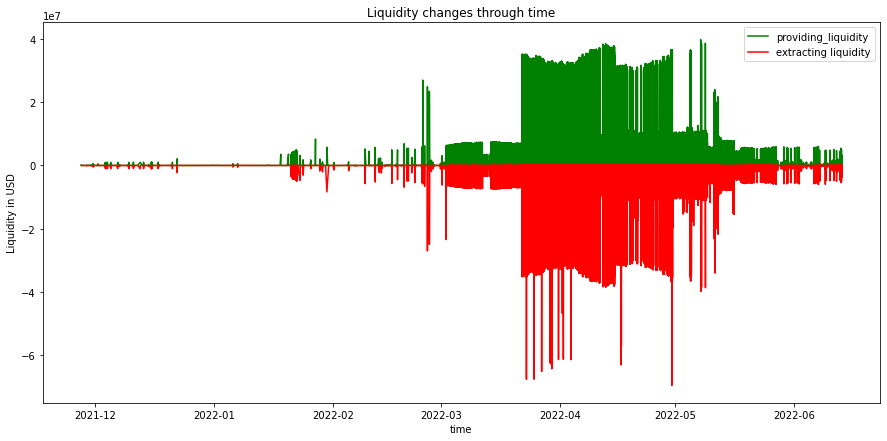

In [16]:
providing_liquidity = liquidity_changes_df[liquidity_changes_df["fixed_liquidity"] >= 0]
extracting_liquidity = liquidity_changes_df[liquidity_changes_df["fixed_liquidity"] < 0]

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(providing_liquidity["time"], providing_liquidity["fixed_liquidity"], color='g', label='providing_liquidity')
ax.plot(extracting_liquidity["time"], extracting_liquidity["fixed_liquidity"], color='r', label='extracting liquidity')
ax.set_xlabel("time")
ax.set_ylabel("Liquidity in USD")
ax.legend()
ax.set_title("Liquidity changes through time")
plt.show()

Visualization looks noisy and it is required to check liquidity values change over time and find a way how to show it properly. Conform the sum of all provided and extracted liquidity can be seen that makers provided 93 427 666 USD to the platform. There will be performed grouping of all liquidity changes by maker to see several aspects:

1. Did this maker extract liquidity or he is still providing it and what is the size of still opened position;
2. How much money of fees did this maker collect;
3. Amount of provided quote tokens;
4. Mean provided upper bound and mean provided lower bound;

In [17]:
makers_perspective_df = liquidity_changes_df[["maker", "quote_fee", "fixed_liquidity", "quote"]].groupby("maker").sum()
makers_mean_bounds_df = liquidity_changes_df[["maker", "lower_bound", "upper_bound"]].groupby("maker").mean()
makers_liquidity_providing = providing_liquidity[["maker", "fixed_liquidity"]].groupby("maker").sum()
makers_liquidity_extracting = extracting_liquidity[["maker", "fixed_liquidity"]].groupby("maker").sum()
makers_liquidity_changes_counts = liquidity_changes_df[["maker", "fixed_liquidity"]].groupby("maker").count()

makers_perspective_df.sort_index(inplace=True)
makers_mean_bounds_df.sort_index(inplace=True)
makers_liquidity_providing.sort_index(inplace=True)
makers_liquidity_extracting.sort_index(inplace=True)

makers_perspective_df["mean_lower_bound"] = makers_mean_bounds_df["lower_bound"]
makers_perspective_df["mean_upper_bound"] = makers_mean_bounds_df["upper_bound"]
makers_perspective_df["overall_provided_liquidity"] = makers_liquidity_providing["fixed_liquidity"]
makers_perspective_df["overall_extracted_liquidity"] = makers_liquidity_extracting["fixed_liquidity"]
makers_perspective_df["changes_count"] = makers_liquidity_changes_counts["fixed_liquidity"]

makers_perspective_df.sort_values("quote_fee", inplace=True)
makers_perspective_df

quote_fee  fixed_liquidity  \
maker                                                                       
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a  0.000000e+00     3.024958e+00   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da  0.000000e+00     2.121648e-01   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e  0.000000e+00     2.608519e-01   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb  0.000000e+00     1.723370e+00   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1  0.000000e+00     1.574986e+01   
...                                                  ...              ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e  4.896962e+05     1.308155e+07   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  5.051075e+05    -8.342415e+05   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  7.409911e+05    -1.957784e+07   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e  1.105782e+06     1.280569e-09   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  1.949788e+06    -2.120032e-09   

                                                   quote  mean_lower_bound  \
maker                                                                        
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a  0.000000e+00      37178.050845   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da  1.130000e+00       2050.048490   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e  1.510000e+00       2469.101075   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb  0.000000e+00      38540.774401   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1  2.000000e+00          1.134275   
...                                                  ...               ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e  1.005260e+07         12.136231   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  4.532833e+06         77.977092   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  3.089670e+06          3.969630   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e -3.715146e+06         62.155604   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  3.100574e+07      14698.758998   

                                            mean_upper_bound  \
maker                                                          
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a      4.450981e+04   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da      3.064374e+03   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e      3.690766e+03   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb      4.641893e+04   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1      1.705696e+00   
...                                                      ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e      1.518723e+01   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd      1.665579e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9      5.065420e+00   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e      1.169285e+02   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7      6.821000e+35   

                                            overall_provided_liquidity  \
maker                                                                    
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                3.024958e+00   
0x76a0d0e3e13e91923d01d11d291e18ddc76061da                2.121648e-01   
0x77dfe2ae646ae67c23189d49bae5985bed8f851e                2.608519e-01   
0x77f07ab7b444c7c9fcfafc76c053a810cd6203cb                1.723370e+00   
0x78366a722edd130ca1b05b269bf3c0e50239c9a1                1.574986e+01   
...                                                                ...   
0xe77dd81813bd06d74a30d1b2c07418906456498e                6.156079e+10   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd                4.602895e+09   
0x70332de459d5554a9a310a7c4f7c6069c73604f9                1.020124e+11   
0xf8489bcef22d3282bb884b9e9cc708bb465c075e                5.587856e+08   
0x9c1e0c67aa30c063f341885b12cb81cc94613fc7                1.083119e+09   

                                            overall_extracted_liquidity  \
maker                                                                     
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                          NaN   
0x76a0d0e

In [18]:
makers_perspective_df.sort_values("changes_count")

quote_fee  fixed_liquidity  \
maker                                                                        
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a       0.000000     3.024958e+00   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57       0.000000     1.958486e-02   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e       0.000000     3.228415e+00   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7       0.000000     2.525356e-01   
0xa080aedd8030e20f39faf056412fc6e32e1de78b       0.000000     1.126201e+00   
...                                                   ...              ...   
0x675e328b73e15cd41acd2828b83b417687c36bba  170409.008415     1.798917e+04   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  505107.478784    -8.342415e+05   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be  308325.682886    -6.428470e+05   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  740991.144164    -1.957784e+07   
0xe77dd81813bd06d74a30d1b2c07418906456498e  489696.174135     1.308155e+07   

                                                   quote  mean_lower_bound  \
maker                                                                        
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a  0.000000e+00      3.717805e+04   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57  1.000000e+00      2.954278e-39   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e  5.000000e+00      7.070295e+00   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7  1.540000e+00      2.606091e+03   
0xa080aedd8030e20f39faf056412fc6e32e1de78b  6.000000e+01      2.954278e-39   
...                                                  ...               ...   
0x675e328b73e15cd41acd2828b83b417687c36bba -3.682497e+05      9.443748e+03   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd  4.532833e+06      7.797709e+01   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be  6.783113e+06      1.037030e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9  3.089670e+06      3.969630e+00   
0xe77dd81813bd06d74a30d1b2c07418906456498e  1.005260e+07      1.213623e+01   

                                            mean_upper_bound  \
maker                                                          
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a      4.450981e+04   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57      3.384921e+38   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e      1.770516e+01   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7      3.918979e+03   
0xa080aedd8030e20f39faf056412fc6e32e1de78b      3.384921e+38   
...                                                      ...   
0x675e328b73e15cd41acd2828b83b417687c36bba      1.596039e+04   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd      1.665579e+02   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be      1.764335e+02   
0x70332de459d5554a9a310a7c4f7c6069c73604f9      5.065420e+00   
0xe77dd81813bd06d74a30d1b2c07418906456498e      1.518723e+01   

                                            overall_provided_liquidity  \
maker                                                                    
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                3.024958e+00   
0xa1bfe87c09d05e3349fe661d62e8cee215db5a57                1.958486e-02   
0xa1adf3dda8d7f62cbab65a86926ba46ac265cf2e                3.228415e+00   
0xa1622da220732bd59cde8de6ca6f07cb398bb1f7                2.525356e-01   
0xa080aedd8030e20f39faf056412fc6e32e1de78b                1.126201e+00   
...                                                                ...   
0x675e328b73e15cd41acd2828b83b417687c36bba                8.197473e+09   
0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd                4.602895e+09   
0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be                1.340898e+10   
0x70332de459d5554a9a310a7c4f7c6069c73604f9                1.020124e+11   
0xe77dd81813bd06d74a30d1b2c07418906456498e                6.156079e+10   

                                            overall_extracted_liquidity  \
maker                                                                     
0x7cc38a05436c19b6bbc6f36c319e0b88bfc8b71a                          NaN 

In [19]:
print("overall collected quote fee = " + str(makers_perspective_df["quote_fee"].sum()))
print("available liquidity at the end of period = " + str(makers_perspective_df["fixed_liquidity"].sum()))
print("positive liquidity flow = " + str(makers_perspective_df["overall_provided_liquidity"].sum()))
print("negative liquidity flow = " + str(makers_perspective_df["overall_extracted_liquidity"].sum()))

overall collected quote fee = 8784884.633043181
available liquidity at the end of period = 11272513.221666994
positive liquidity flow = 209380468958.78534
negative liquidity flow = -209369196445.56366


In [20]:
print(liquidity_changes_df[liquidity_changes_df["maker"] == '0x9c1e0c67aa30c063f341885b12cb81cc94613fc7']["pool_name"].unique())
liquidity_changes_df[liquidity_changes_df["maker"] == '0x9c1e0c67aa30c063f341885b12cb81cc94613fc7']

['vETH' 'vBTC' 'vAVAX' 'vLUNA' 'vSOL' 'vCRV']


id  \
0      0x7871b4fe6113ac31c8be911146b109575cfb9ee90b13...   
1      0x7dba9c535f6c595ab39eeec818d89b34783442bafa81...   
2      0xc438a7cd8fee202ce2b53761811ef05f85095933b27e...   
3      0xec1e410b931f920c4aa3ae105e63463142b310fbe959...   
22     0x1c761e2266b87c9f047eab4a996e1bfc38855f1ad397...   
...                                                  ...   
17248  0x1f2de8e6db9b4796953e1b7ad01d5a72127d187f4104...   
17253  0x859b22078e59214e23801fc997b555cc16462a65226c...   
17294  0x4df543f555e12c717dc18fd867d83ec4ef474c6a82ff...   
17295  0xbef90ed69acaf7408248593ce1ada8d371aa457c2bf3...   
17399  0xa2081d280ae57b8d16150f230d6fa6c6e8b5545981a8...   

                                            maker       base          quote  \
0      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  46.254982  200000.000000   
1      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   0.012181      50.000000   
2      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   3.572179  200000.000000   
3      0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   0.000921      50.000000   
22     0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   3.255201  200000.000000   
...                                           ...        ...            ...   
17248  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  -0.001449     -62.354889   
17253  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   2.902825  124926.543699   
17294  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   2.838812  125000.000000   
17295  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  -2.884910 -125698.570007   
17399  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7  -2.876725 -123369.742255   

       quote_fee  block_number_log_index   timestamp                time  \
0       0.000000               515557003  1638000985 2021-11-27 08:16:25   
1       0.000000               515554004  1638000985 2021-11-27 08:16:25   
2       0.000000               515555003  1638000985 2021-11-27 08:16:25   
3       0.000000               515552004  1638000985 2021-11-27 08:16:25   
22      0.000000               568711003  1638135861 2021-11-28 21:44:21   
...          ...                     ...         ...                 ...   
17248   0.000000              4787801007  1648112797 2022-03-24 09:06:37   
17253   0.000000              4787814006  1648112813 2022-03-24 09:06:53   
17294   0.000000              4789248005  1648114625 2022-03-24 09:37:05   
17295  14.853304              4789274008  1648114640 2022-03-24 09:37:20   
17399  59.847145              4791478008  1648117106 2022-03-24 10:18:26   

       day_of_year pool_name   lower_bound   upper_bound  fixed_liquidity  \
0              331      vETH  3.895536e+03  4.313830e+03    120851.329740   
1              331      vETH  2.954278e-39  3.384921e+38         0.780407   
2              331      vBTC  5.171263e+04  5.692287e+04     35648.835497   
3              331      vBTC  2.954278e-39  3.384921e+38         0.214579   
22             332      vBTC  5.360810e+04  5.900932e+04     34058.767589   
...            ...       ...           ...           ...              ...   
17248           83      vBTC  3.317260e+04  5.590748e+04        -2.456931   
17253           83      vBTC  3.317260e+04  5.590748e+04      4922.403691   
17294           83      vBTC  3.297417e+04  5.590748e+04      4817.792844   
17295           83      vBTC  3.317260e+04  5.590748e+04     -4922.403691   
17399           83      vBTC  3.297417e+04  5.590748e+04     -4817.792844   

       central_bound  
0       4.104683e+03  
1       1.692461e+38  
2       5.431775e+04  
3       1.692461e+38  
22      5.630871e+04  
...              ...  
17248   4.454004e+04  
17253   4.454004e+04  
17294   4.444082e+04  
17295   4.454004e+04  
17399   4.444082e+04  

[1985 rows x 14 columns]

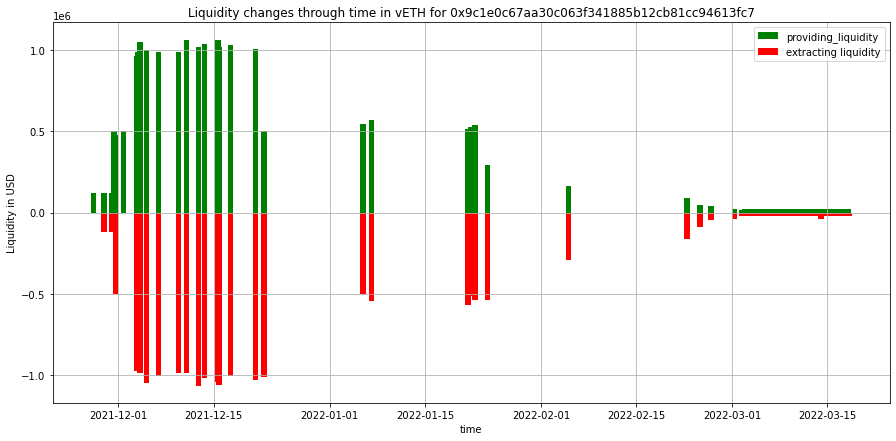

In [21]:
providing_liquidity = liquidity_changes_df[(liquidity_changes_df["fixed_liquidity"] >= 0) &
                                          (liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")]
extracting_liquidity = liquidity_changes_df[(liquidity_changes_df["fixed_liquidity"] < 0) &
                                           (liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")]

fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(providing_liquidity[providing_liquidity["pool_name"] == "vETH"]["time"], 
        providing_liquidity[providing_liquidity["pool_name"] == "vETH"]["fixed_liquidity"], 
        color='g', label='providing_liquidity')
ax.bar(extracting_liquidity[extracting_liquidity["pool_name"] == "vETH"]["time"], 
        extracting_liquidity[extracting_liquidity["pool_name"] == "vETH"]["fixed_liquidity"], 
        color='r', label='extracting liquidity')
ax.set_xlabel("time")
ax.set_ylabel("Liquidity in USD")
ax.legend()
ax.grid()
ax.set_title("Liquidity changes through time in vETH for 0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")
plt.show()

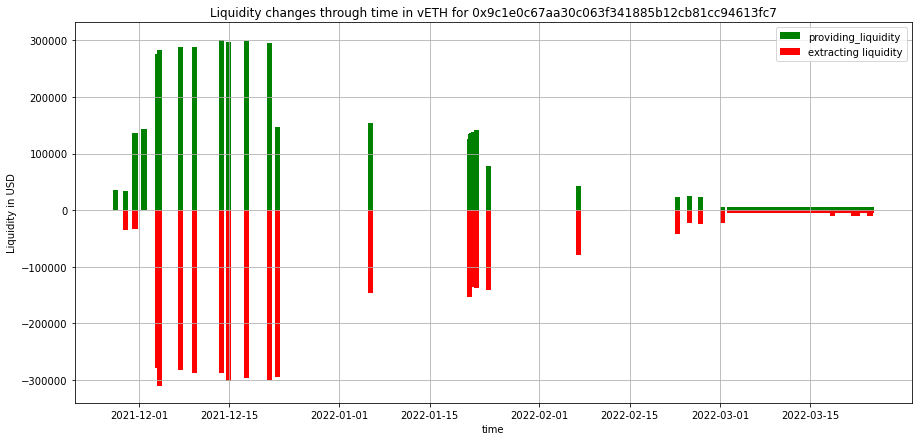

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(providing_liquidity[providing_liquidity["pool_name"] == "vBTC"]["time"], 
        providing_liquidity[providing_liquidity["pool_name"] == "vBTC"]["fixed_liquidity"], 
        color='g', label='providing_liquidity')
ax.bar(extracting_liquidity[extracting_liquidity["pool_name"] == "vBTC"]["time"], 
        extracting_liquidity[extracting_liquidity["pool_name"] == "vBTC"]["fixed_liquidity"], 
        color='r', label='extracting liquidity')
ax.set_xlabel("time")
ax.set_ylabel("Liquidity in USD")
ax.legend()
ax.grid()
ax.set_title("Liquidity changes through time in vETH for 0x9c1e0c67aa30c063f341885b12cb81cc94613fc7")
plt.show()

# Check of the lower and upper bounds distribution referring to the token price to see maker strategy

In order to check theory that maker changes liquidity each time when price starts to go too far from the central bound and there appears a risk that it will go out of the estimated bounds, it is required to get position changes prices. First maker for who will be performed check is the one with biggest amount of collected fees

In [23]:
liquidity_changes_df[liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7"]["pool_name"].unique()

array(['vETH', 'vBTC', 'vAVAX', 'vLUNA', 'vSOL', 'vCRV'], dtype=object)

In [24]:
maker_pool_stats_df = liquidity_changes_df[liquidity_changes_df["maker"] == "0x9c1e0c67aa30c063f341885b12cb81cc94613fc7"
                                    ][["quote_fee", "fixed_liquidity", "pool_name"]].groupby("pool_name").sum()
maker_pool_stats_df

quote_fee  fixed_liquidity
pool_name                                
vAVAX      169697.952774     2.328306e-10
vBTC       412772.337740     9.094947e-13
vCRV       304729.082754     0.000000e+00
vETH       664285.150143    -2.328306e-10
vLUNA      217637.683087     1.047738e-09
vSOL       180665.478389     0.000000e+00

Conform presened stats can be seen that there is a need to look for ```vETH```, ```vBTC``` and ```vCRV``` pools data of the presented trader.

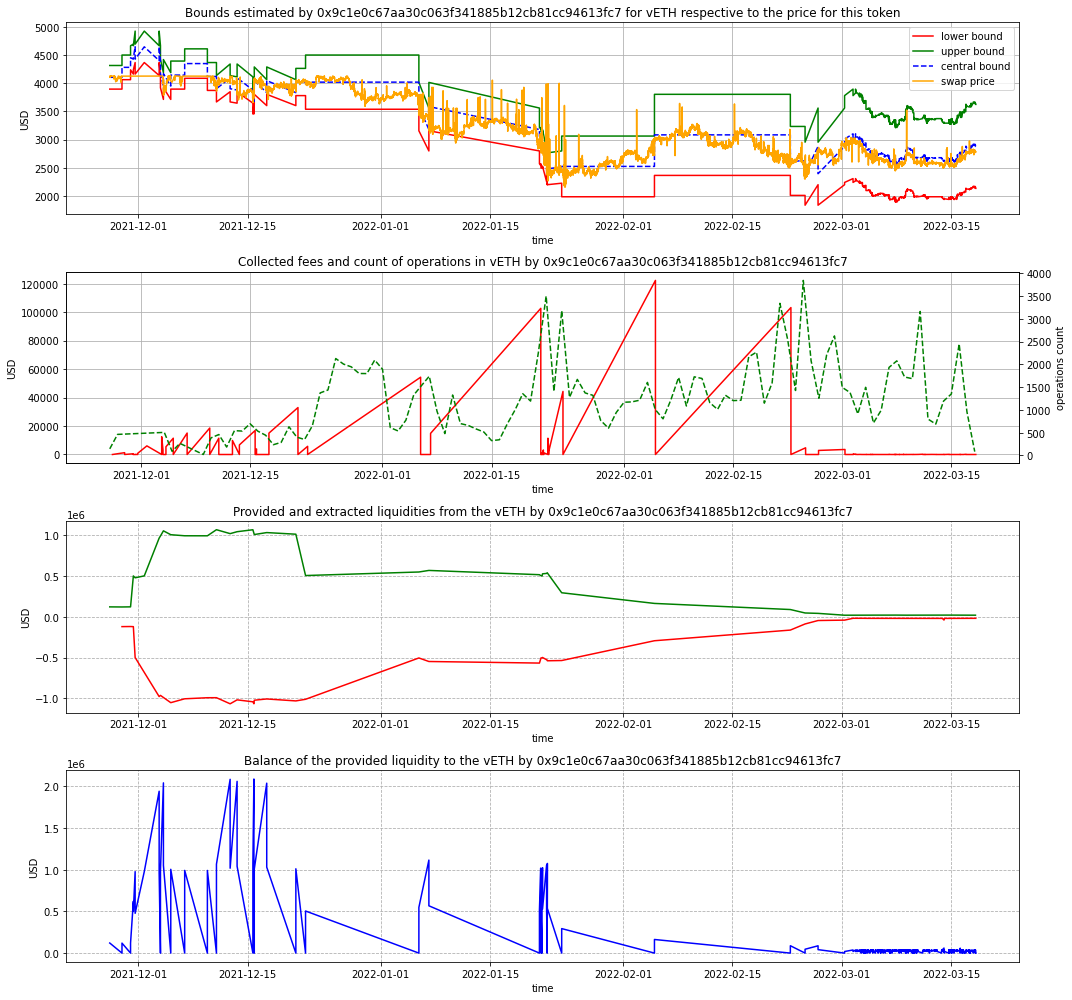

In [25]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x9c1e0c67aa30c063f341885b12cb81cc94613fc7",
                               pool_name="vETH")

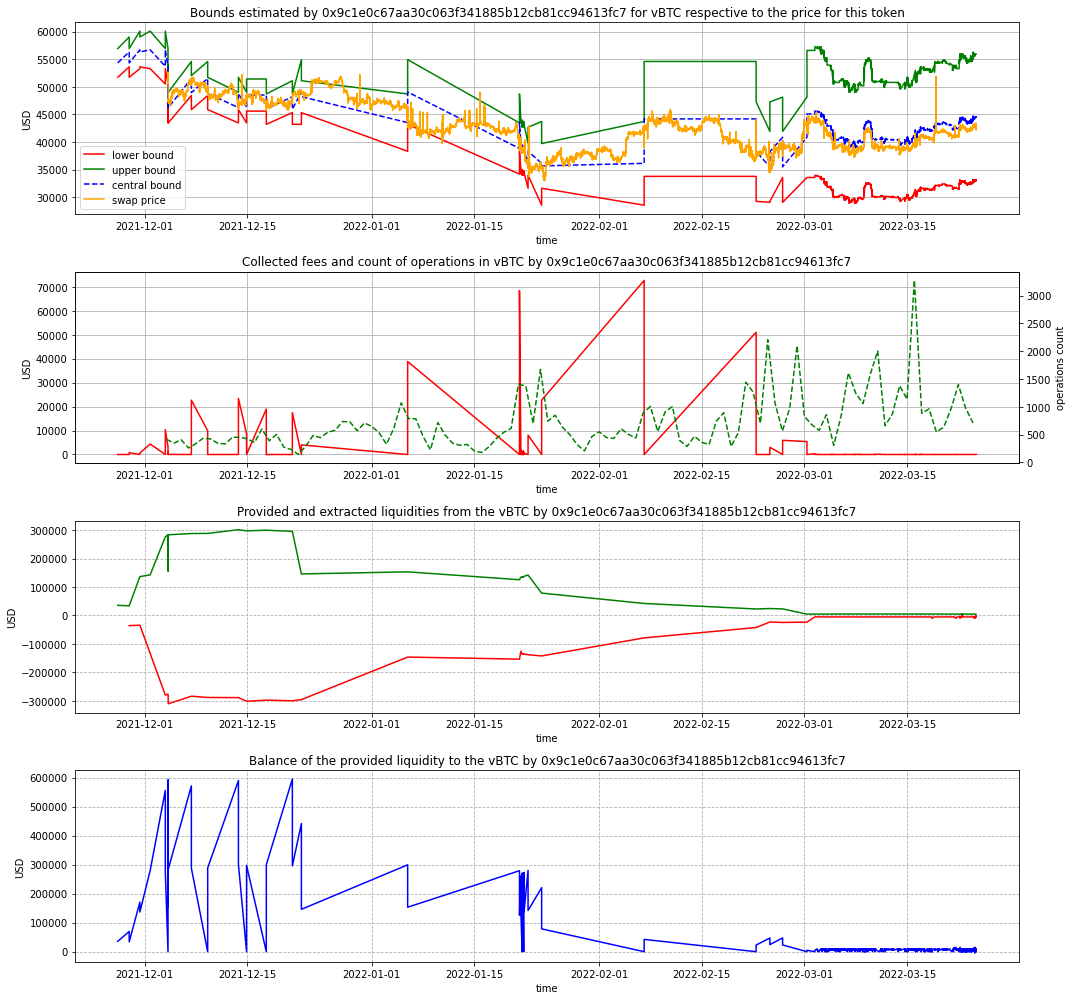

In [26]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x9c1e0c67aa30c063f341885b12cb81cc94613fc7",
                               pool_name="vBTC")

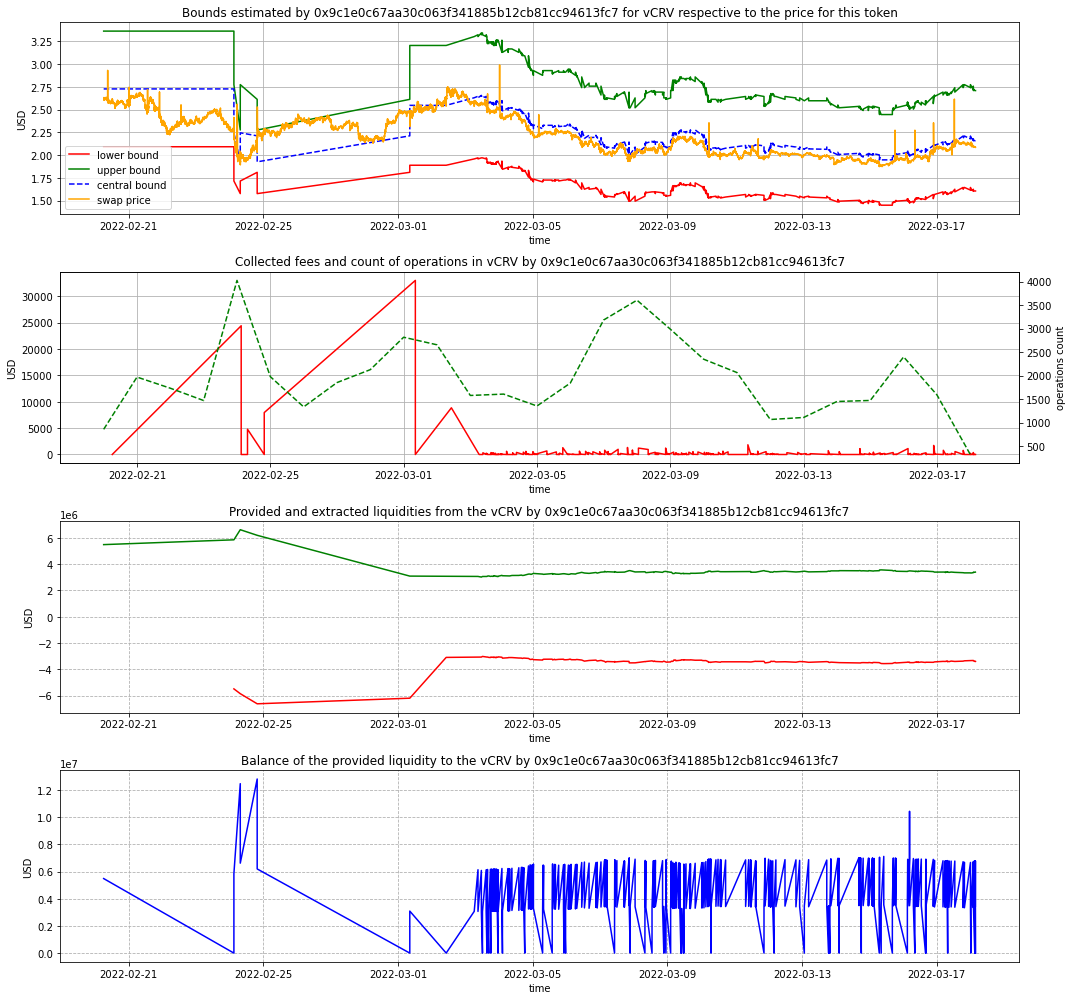

In [27]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x9c1e0c67aa30c063f341885b12cb81cc94613fc7",
                               pool_name="vCRV")

Here is another maker, leading by the number of applied liquidity changes

In [28]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0xe77dd81813bd06d74a30d1b2c07418906456498e"
                        ]["pool_name"].unique()
)

['vSAND' 'vLINK' 'vATOM']


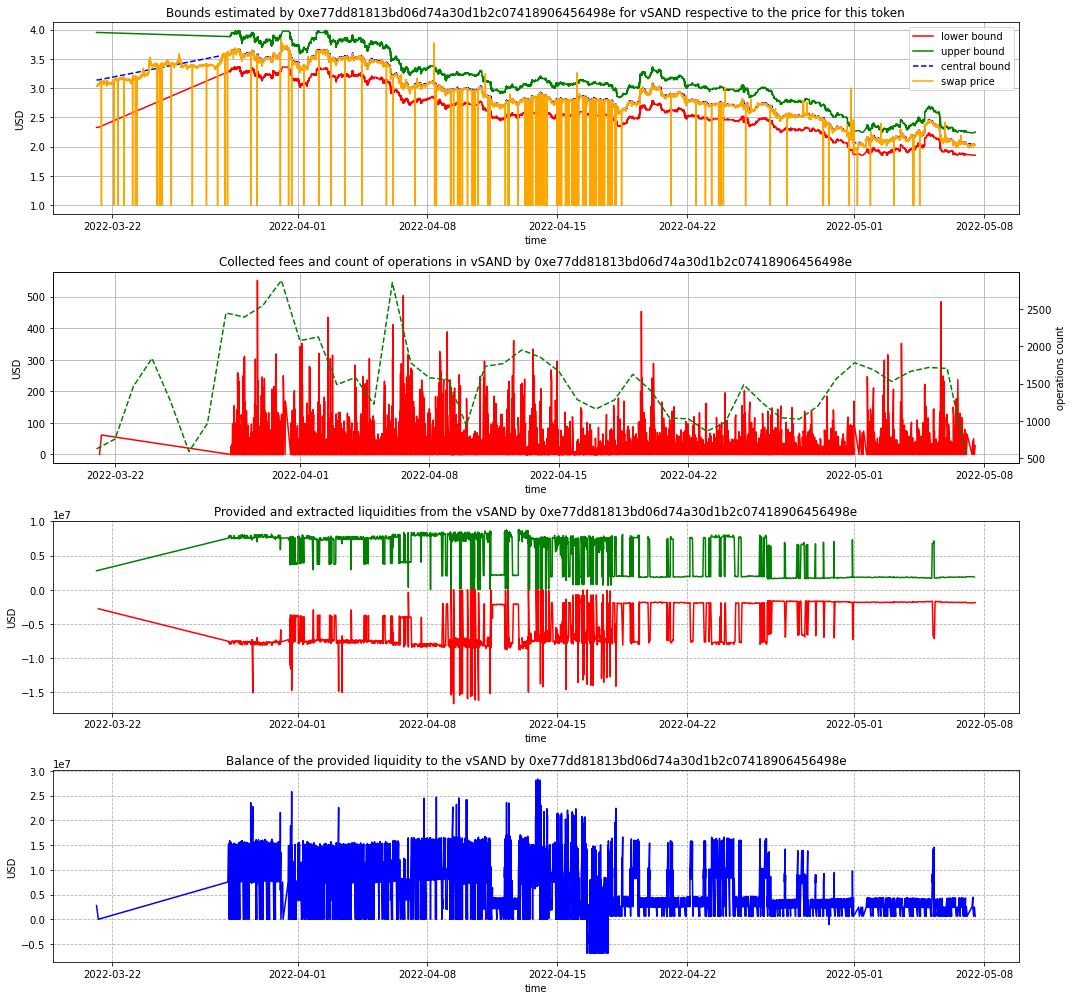

In [29]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vSAND")

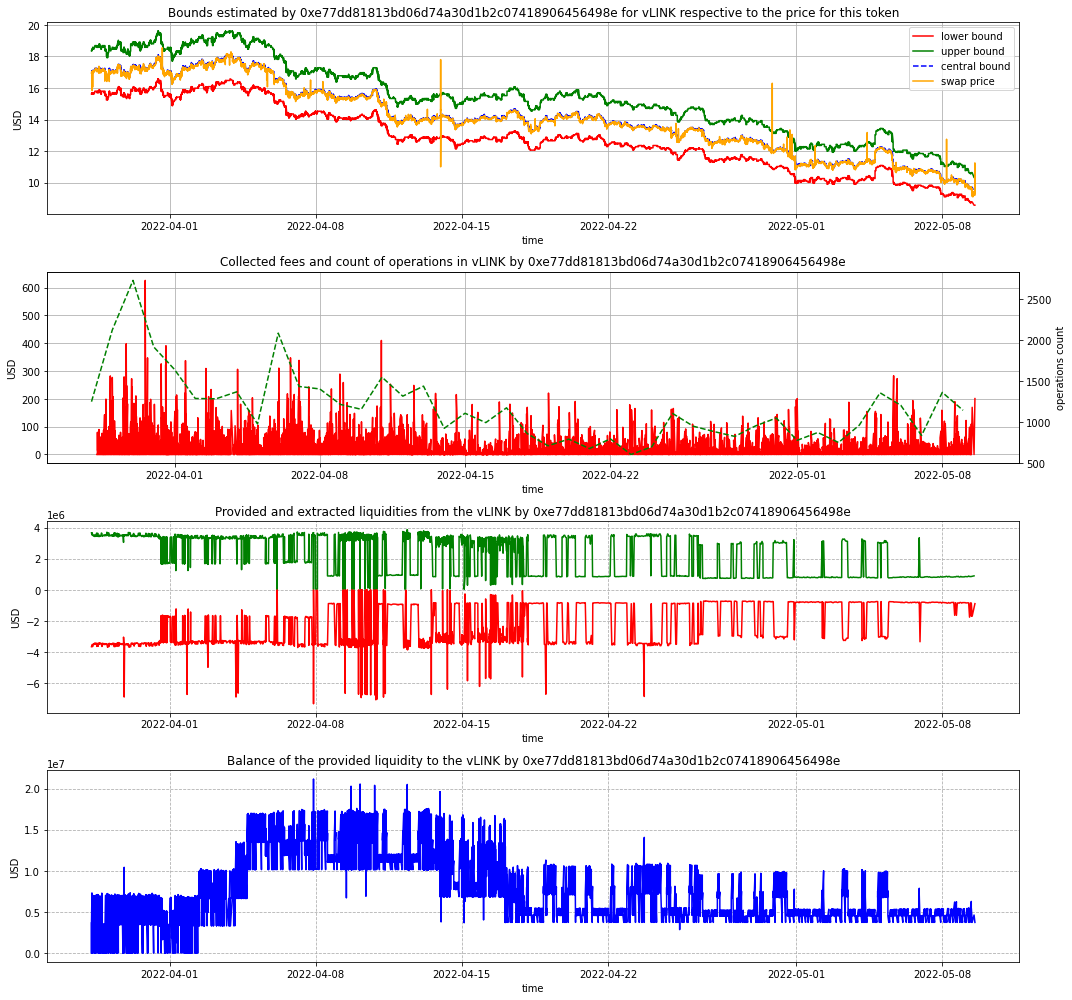

In [30]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vLINK")

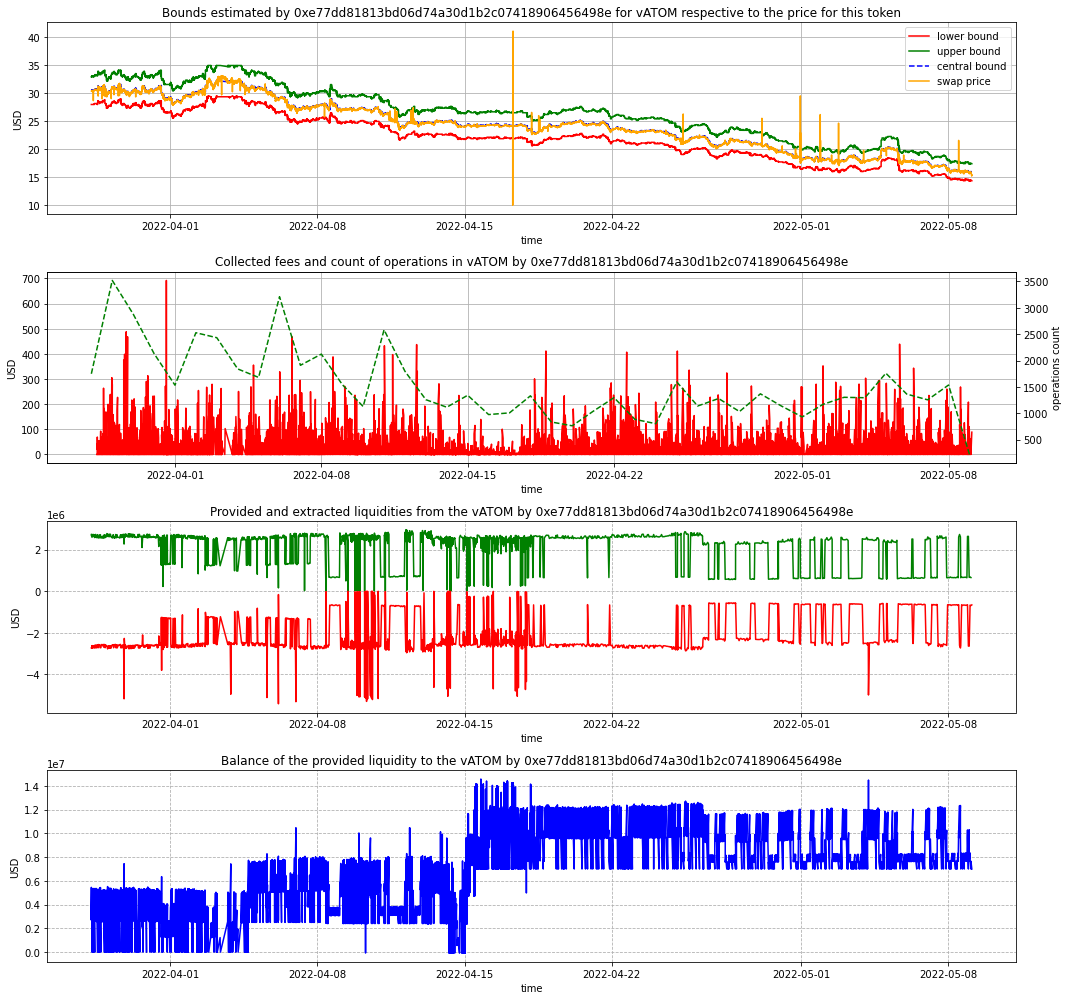

In [31]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0xe77dd81813bd06d74a30d1b2c07418906456498e",
                               pool_name="vATOM")

Based on the presented charts can be seen that makers mostly try to make price distribution to be located between bounds and therefore evade any possible impermanent loss and minimize losses. To ensure that below is reviewed the second maker by count of applied liquidity changes.

In [32]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x70332de459d5554a9a310a7c4f7c6069c73604f9"
                        ]["pool_name"].unique()
)

['vONE' 'vNEAR' 'vFTM']


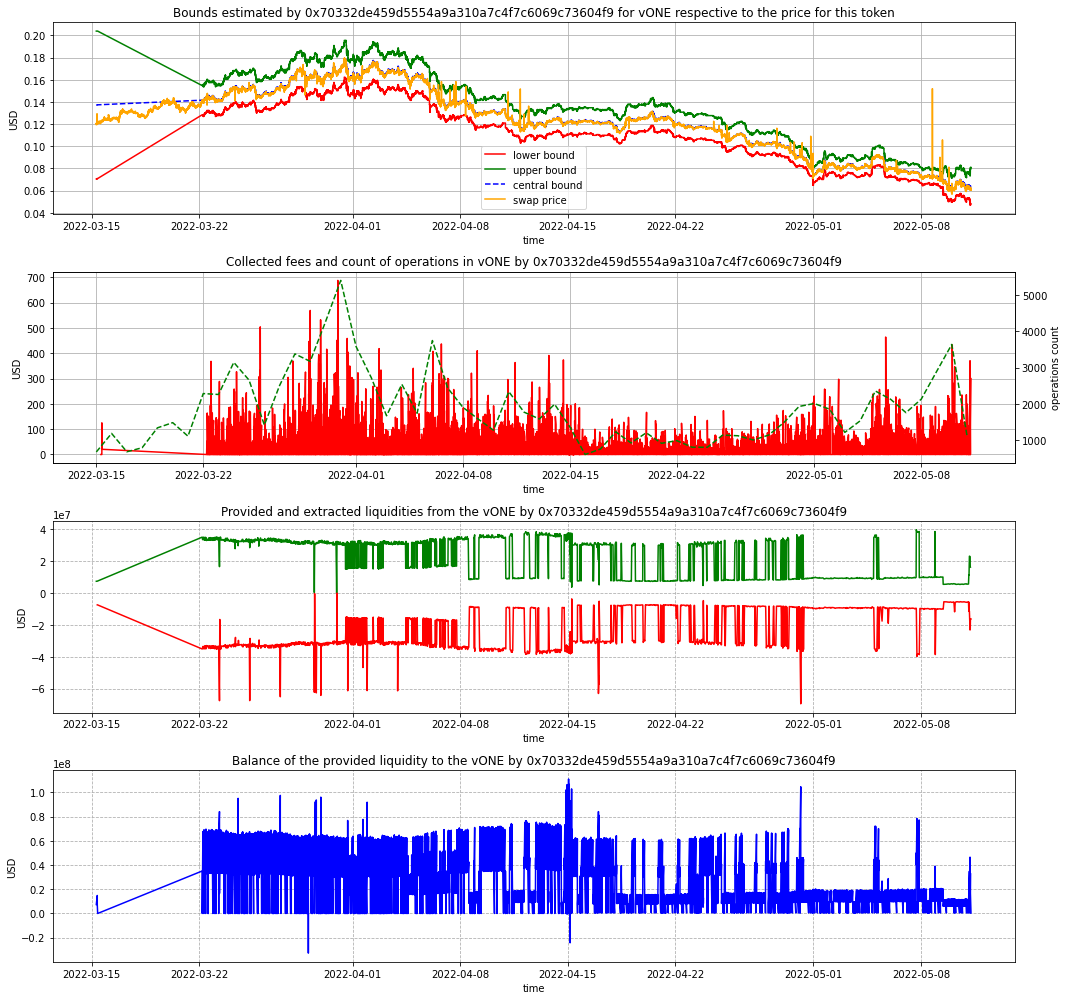

In [33]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vONE")

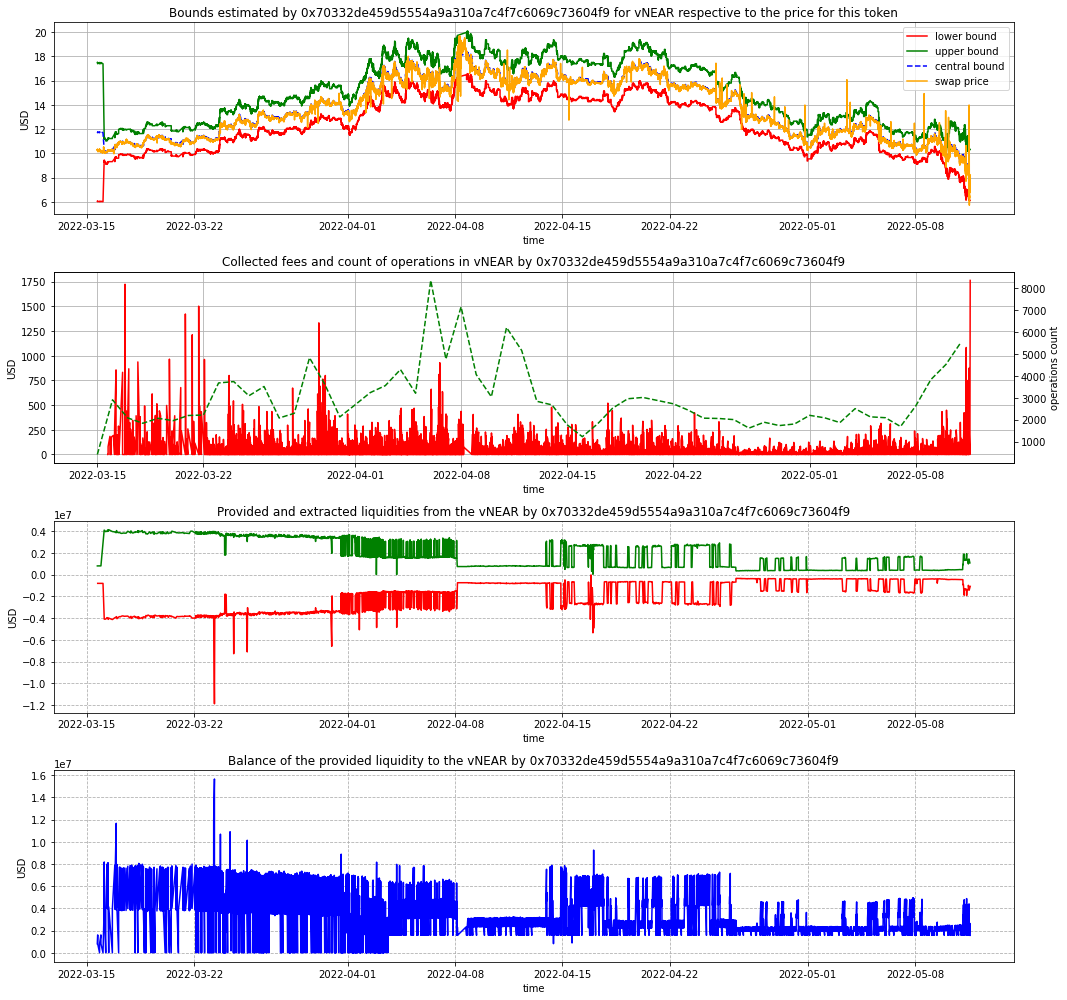

In [34]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vNEAR")

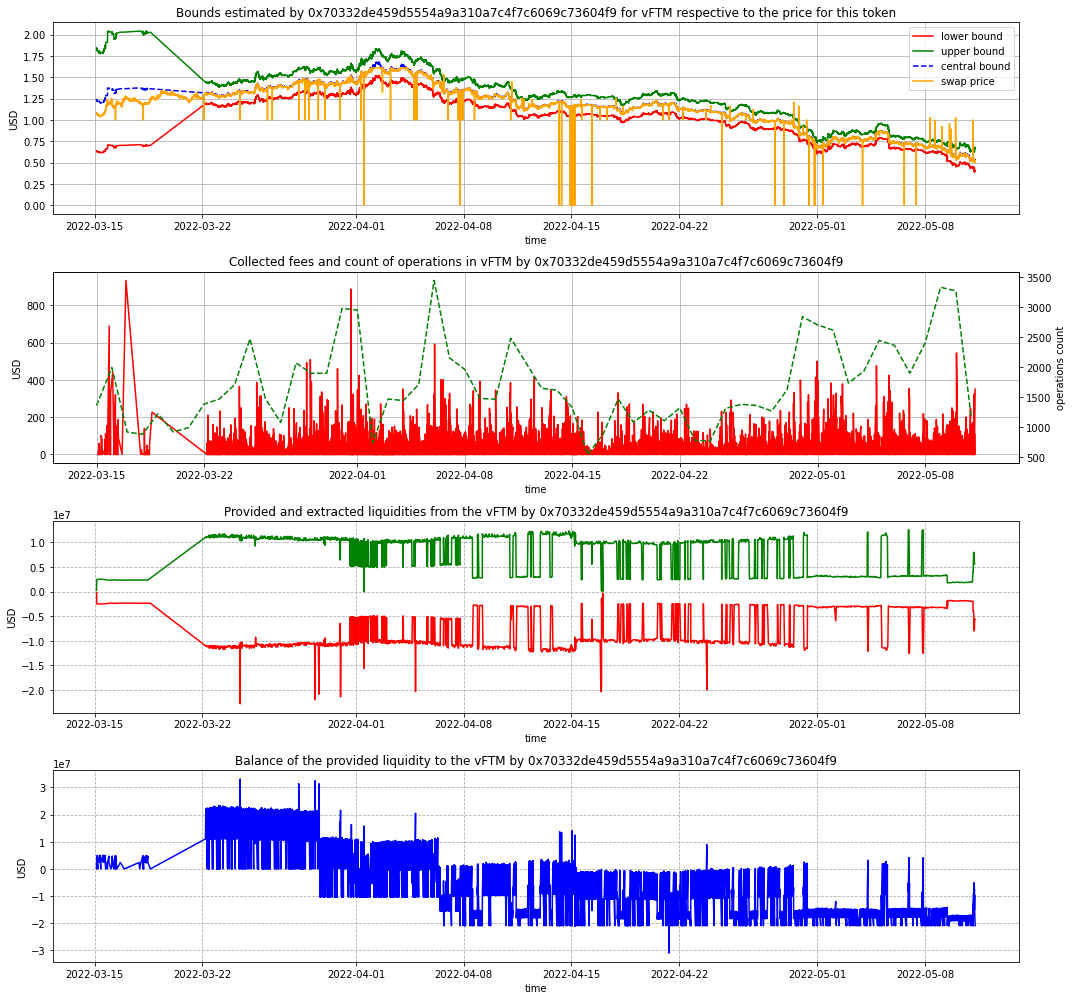

In [35]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x70332de459d5554a9a310a7c4f7c6069c73604f9",
                               pool_name="vFTM")

The third address from the perspective of performed liquidity changes - ```0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be```

While other addresses demonstrate adaptive behavior with setting bounds to track swapping price in such a manner that fees will be collected as much as possible here can be seen that there applied bounds too big to be sure that price will not go out of the bounds

In [36]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be"
                        ]["pool_name"].unique()
)

['vFLOW' 'vBNB' 'vPERP']


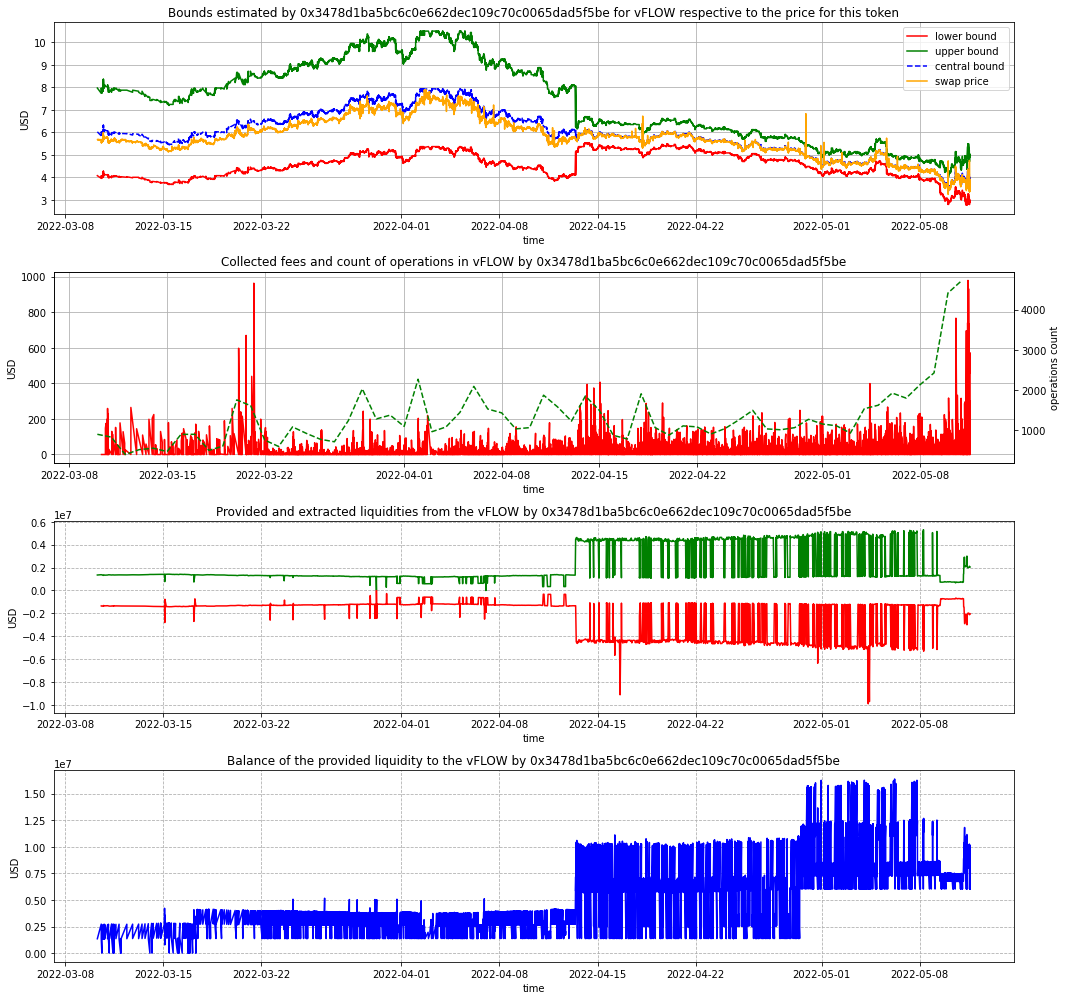

In [37]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vFLOW")

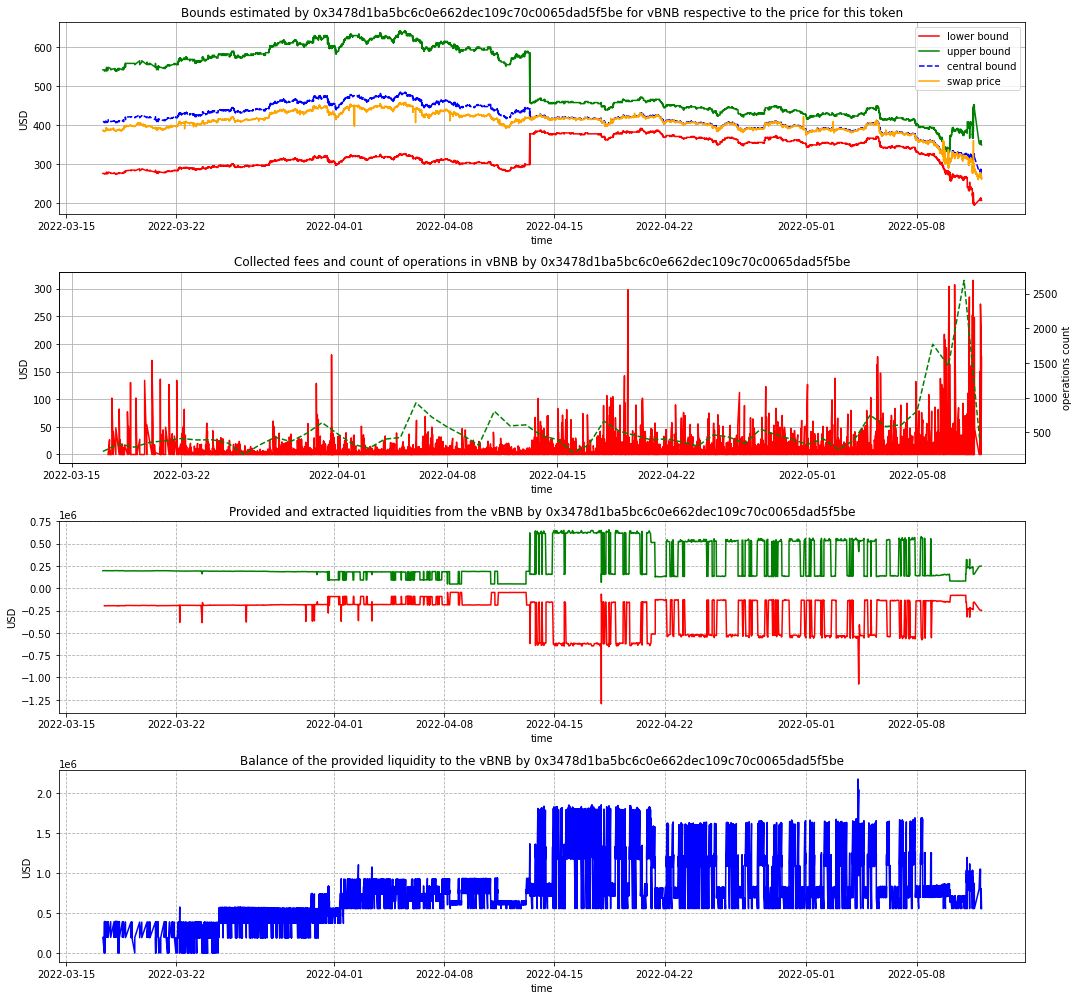

In [38]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vBNB")

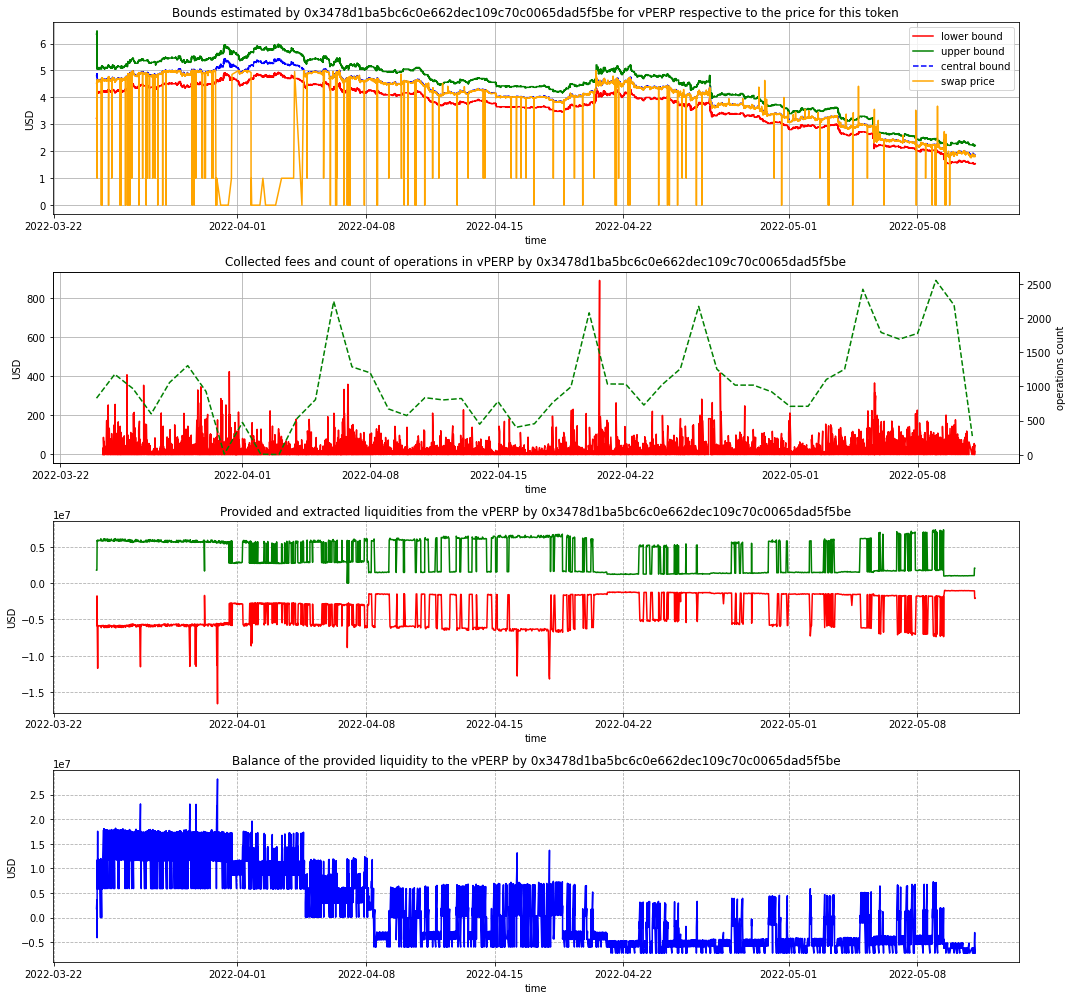

In [39]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x3478d1ba5bc6c0e662dec109c70c0065dad5f5be",
                               pool_name="vPERP")

The fourth address by count of applied liquidity changes - ```0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd```

In [40]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd"
                        ]["pool_name"]
    .unique()
)

['vSOL' 'vAVAX' 'vLUNA']


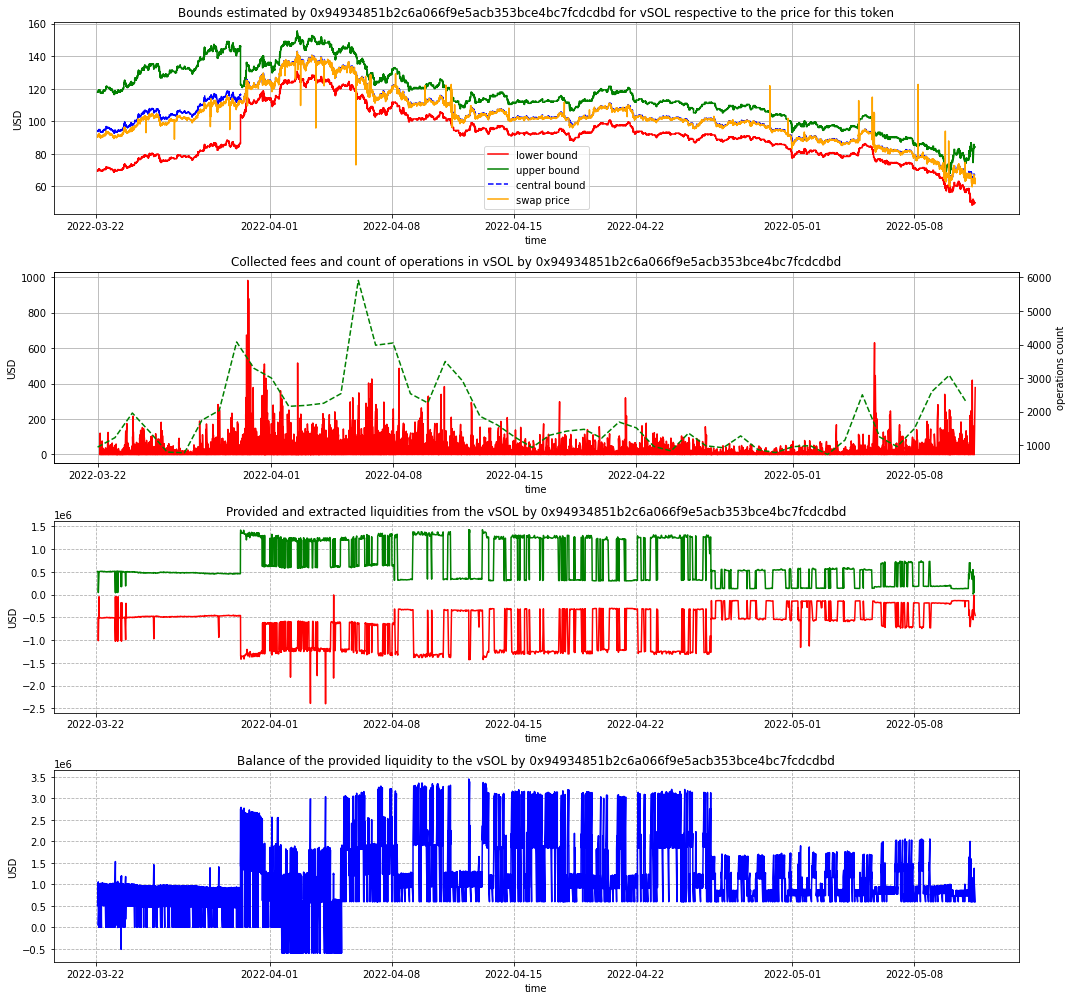

In [41]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vSOL")

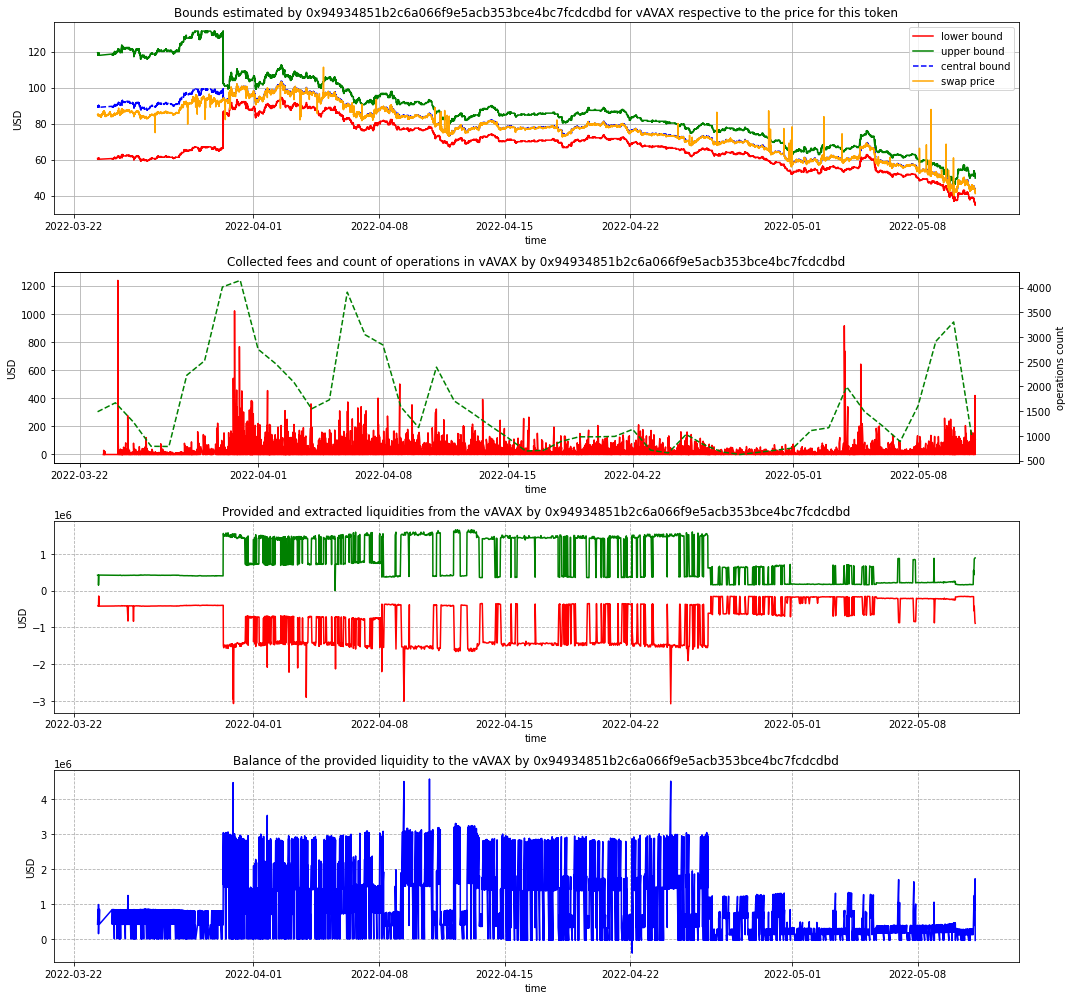

In [42]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vAVAX")

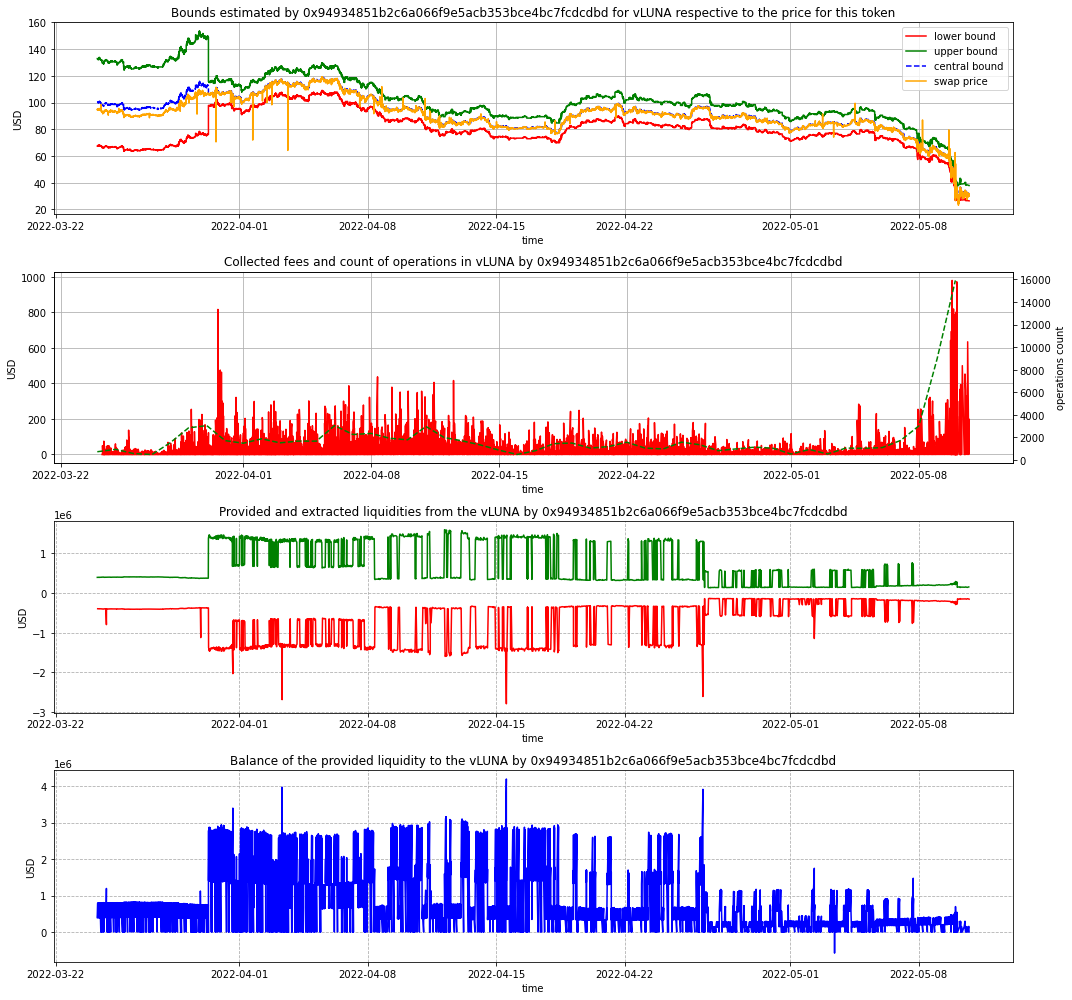

In [43]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x94934851b2c6a066f9e5acb353bce4bc7fcdcdbd",
                               pool_name="vLUNA")

The fifth address by count of liquidity changes is ```0x675e328b73e15cd41acd2828b83b417687c36bba```

In [44]:
print(
    liquidity_changes_df[liquidity_changes_df["maker"] == "0x675e328b73e15cd41acd2828b83b417687c36bba"
                        ]["pool_name"].unique()
)

['vETH' 'vCRV' 'vBTC']


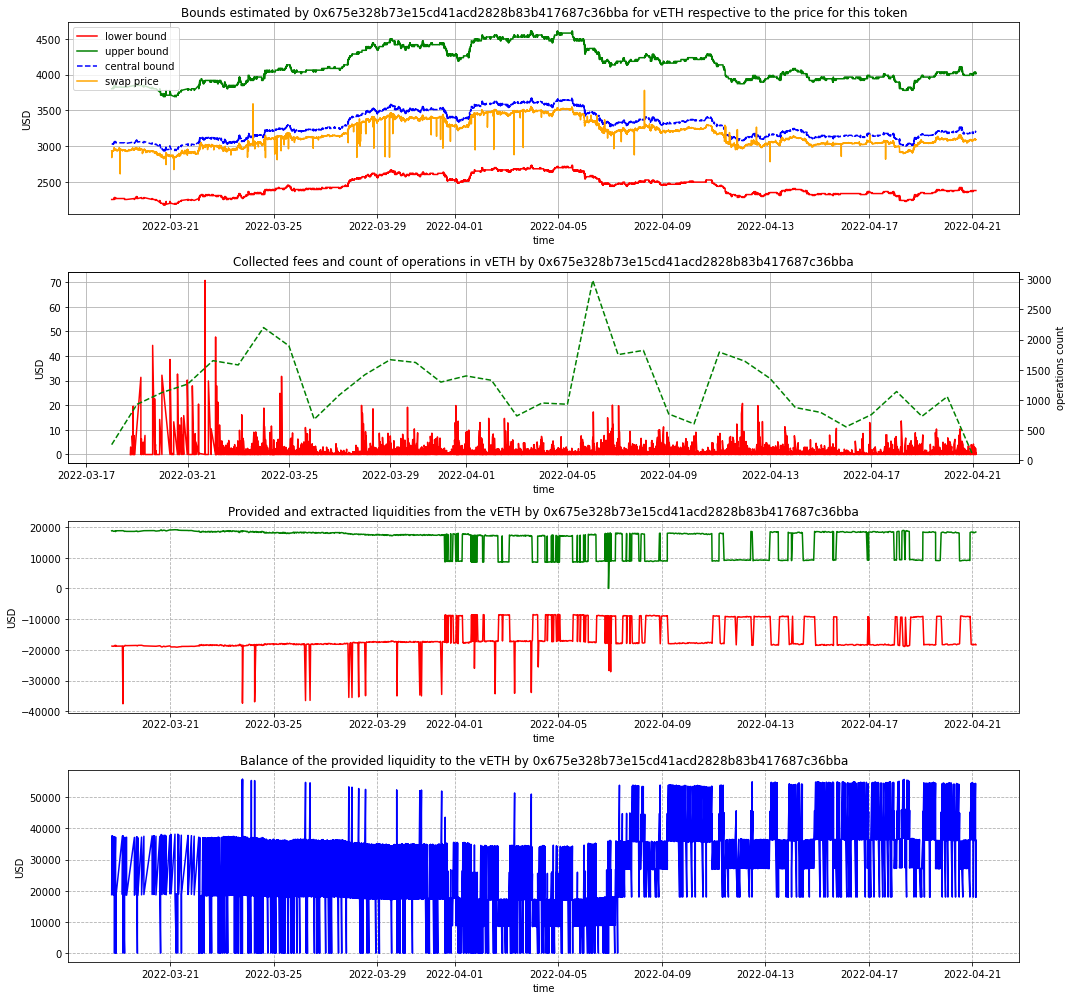

In [45]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba",
                               pool_name="vETH")

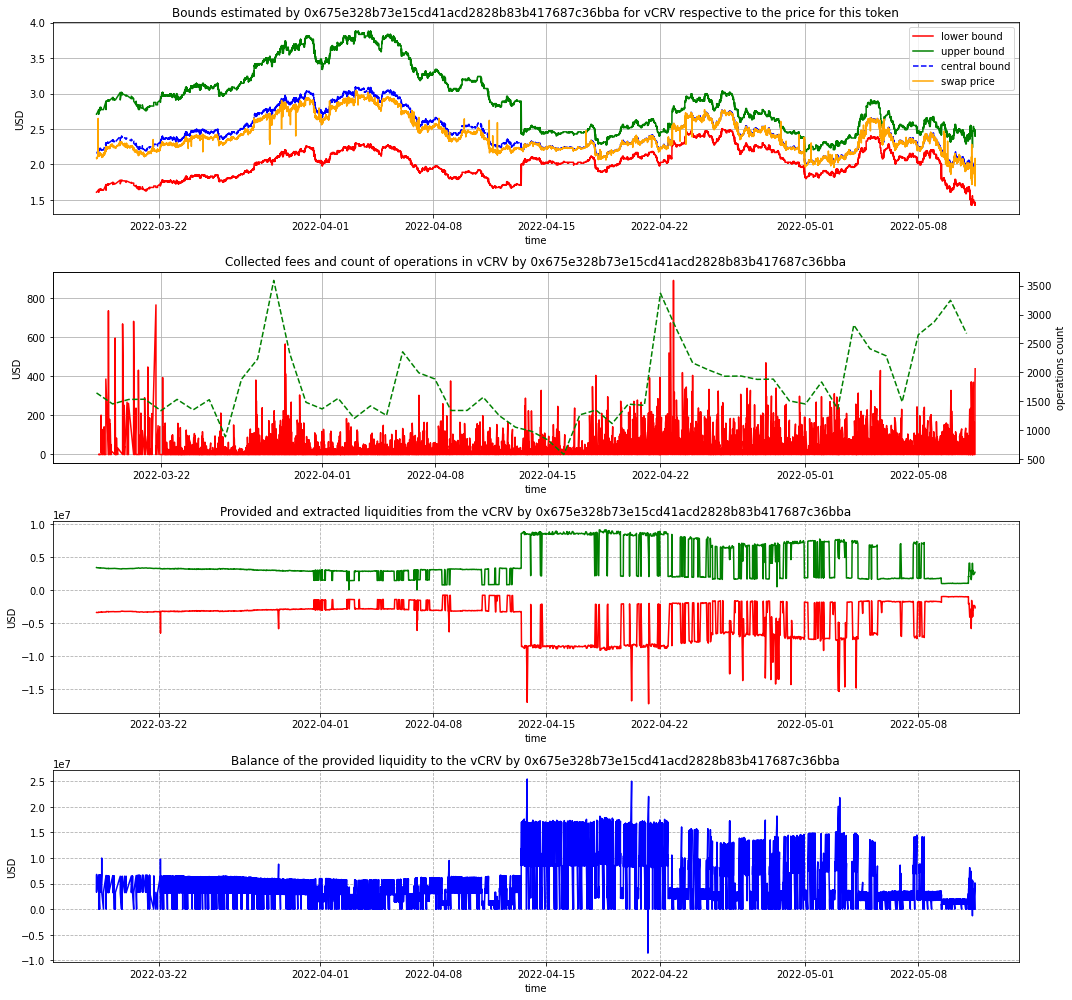

In [46]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba",
                               pool_name="vCRV")

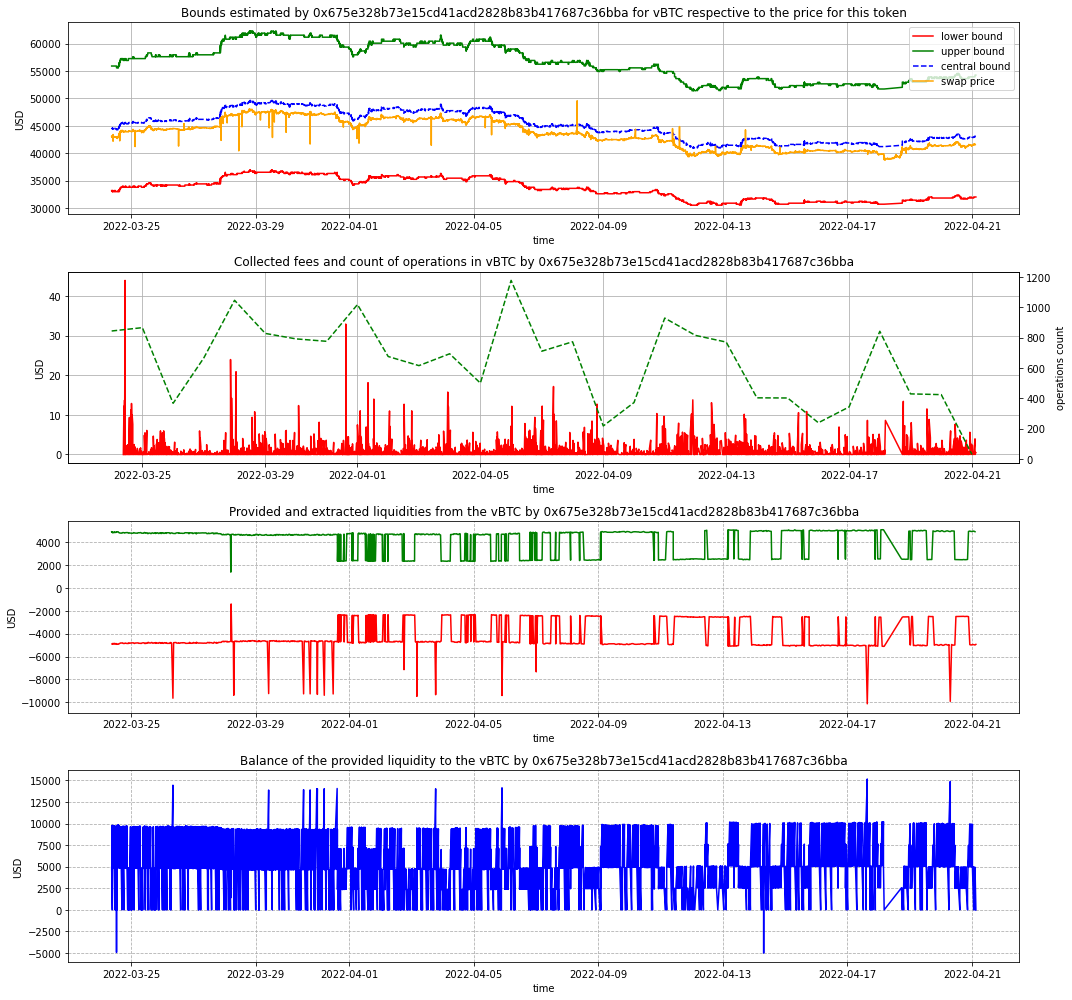

In [47]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df, 
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba",
                               pool_name="vBTC")

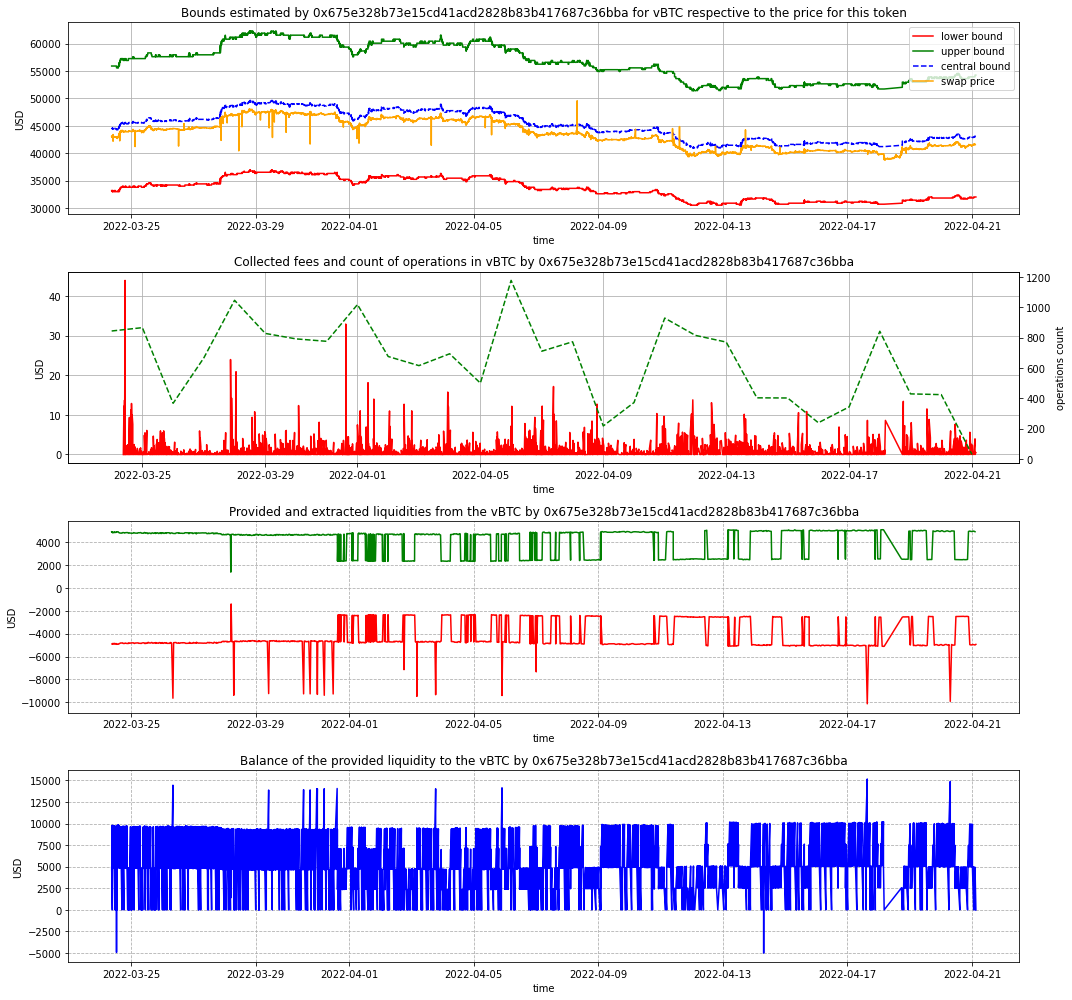

In [48]:
liquidity_maker_individual_flow(liquidity_changes_df, position_changes_df,
                                maker="0x675e328b73e15cd41acd2828b83b417687c36bba", 
                                pool_name='vBTC')

# Balance of the provided liquidity for each trader separately and overall

## Overall distribution

There is a need to find distribution of the overall available liquidity for each of the pools

In [49]:
maker_pool_grouped_liquidity = liquidity_changes_df[["maker", "time", "pool_name", "fixed_liquidity"]
                                 ].groupby(["pool_name", "maker", "time"]).sum()
maker_pool_grouped_liquidity = maker_pool_grouped_liquidity.reset_index()
maker_pool_grouped_liquidity.sort_values("time", inplace=True)
maker_pool_grouped_liquidity = maker_pool_grouped_liquidity.reset_index()
maker_pool_grouped_liquidity.drop(columns=["index"], inplace=True)
maker_pool_grouped_liquidity

pool_name                                       maker  \
0          vBTC  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   
1          vETH  0x9c1e0c67aa30c063f341885b12cb81cc94613fc7   
2          vETH  0x35952141922ee99a04e016c967c3f0ad589ea958   
3          vETH  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf   
4          vETH  0xb3344d84ad8dd6b96301991bf12dc739e226c9cf   
...         ...                                         ...   
97213     vAAVE  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420   
97214      vAPE  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1   
97215     vAAVE  0xd3fab52a0c93346f23a9b9b24fd45ea0b8dd3420   
97216     vAVAX  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1   
97217     vAVAX  0x377e6326a8e2ce4a856d31605ca33505ad2b57b1   

                     time  fixed_liquidity  
0     2021-11-27 08:16:25     35649.050076  
1     2021-11-27 08:16:25    120852.110147  
2     2021-11-27 09:06:32       386.315245  
3     2021-11-27 10:17:13       373.141372  
4     2021-11-27 11:29:01      -373.141372  
...                   ...              ...  
97213 2022-06-13 10:56:51   -146260.729784  
97214 2022-06-13 10:58:11      3917.139686  
97215 2022-06-13 10:59:12    152196.723027  
97216 2022-06-13 11:03:18     -1878.686957  
97217 2022-06-13 11:04:49      1877.644621  

[97218 rows x 4 columns]

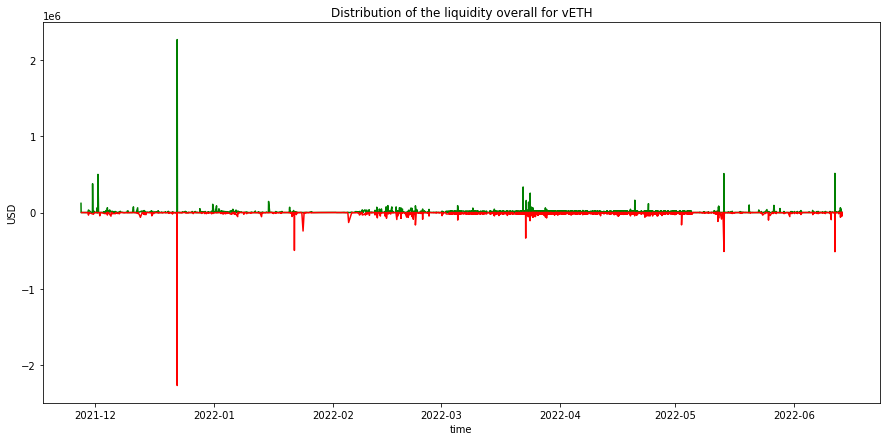

In [50]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
pool_liquidity_movement = maker_pool_grouped_liquidity[maker_pool_grouped_liquidity["pool_name"] == "vETH"]

ax.plot(pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] >= 0]["time"],
       pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] >= 0]["fixed_liquidity"],
       color='g', label='investments')
ax.plot(pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] < 0]["time"],
       pool_liquidity_movement[pool_liquidity_movement["fixed_liquidity"] < 0]["fixed_liquidity"],
       color='r', label='extractions')
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.set_title("Distribution of the liquidity overall for vETH")
plt.show()

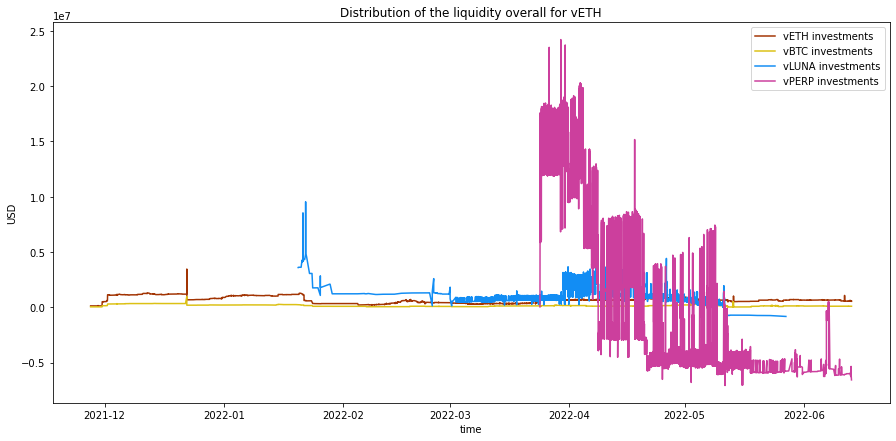

In [51]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for pool in ["vETH", "vBTC", "vLUNA", "vPERP"]:
    col = (np.random.random(), np.random.random(), np.random.random())
    pool_liquidity_movement = maker_pool_grouped_liquidity[maker_pool_grouped_liquidity["pool_name"] == pool]
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement["time"], pool_liquidity_movement["liquidity_balance"],
            color=col, label=pool+' investments')
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.set_title("Distribution of the liquidity overall for vETH")
plt.show()

## Liquidity over time with daily results

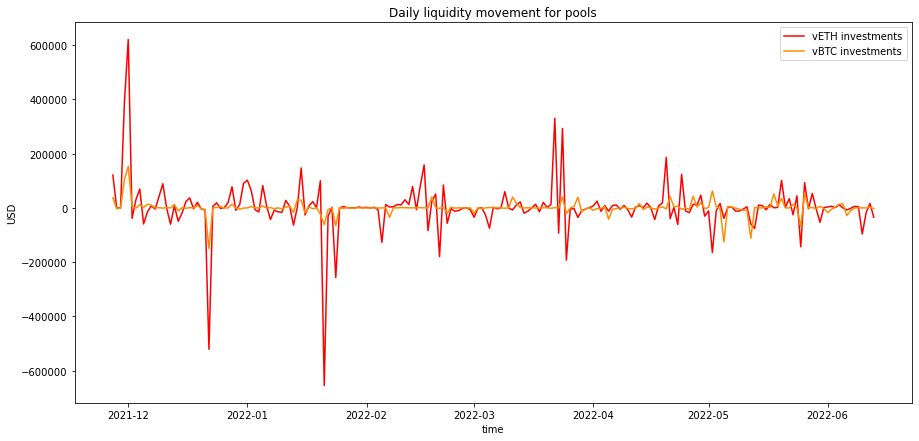

In [52]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vETH", "vBTC"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    daily_liquidity_movement = pool_liquidity_movement.resample("D").sum()
    ax.plot(daily_liquidity_movement.index, daily_liquidity_movement["fixed_liquidity"],
            color=colors[color_index], label=pool+' investments')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.set_title("Daily liquidity movement for pools")
plt.show()

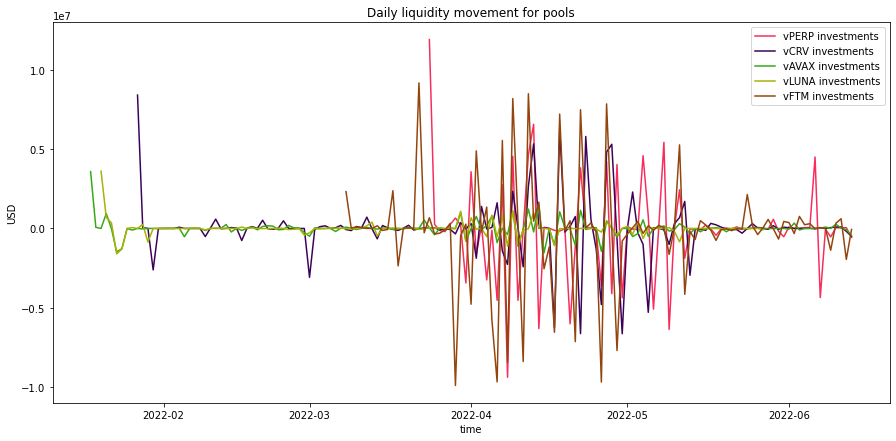

In [53]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for pool in ["vPERP", "vCRV", "vAVAX", "vLUNA", "vFTM"]:
    col = (np.random.random(), np.random.random(), np.random.random())
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    daily_liquidity_movement = pool_liquidity_movement.resample("D").sum()
    ax.plot(daily_liquidity_movement.index, daily_liquidity_movement["fixed_liquidity"],
            color=col, label=pool+' investments')
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.set_title("Daily liquidity movement for pools")
plt.show()

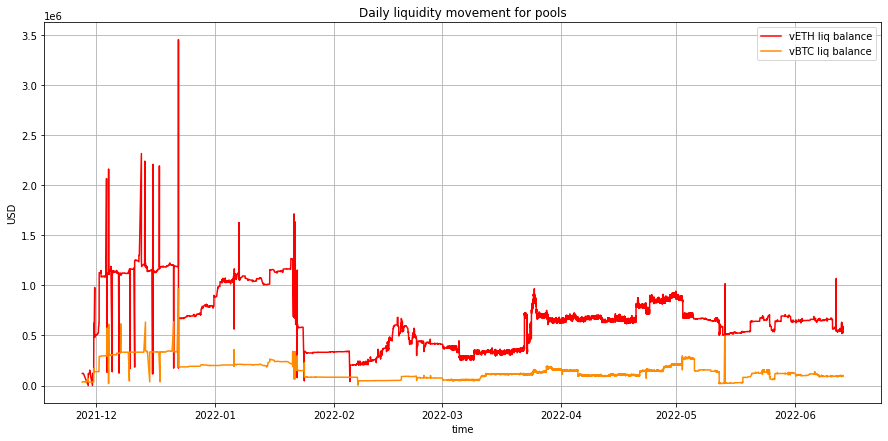

In [54]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vETH", "vBTC"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement.index, pool_liquidity_movement["liquidity_balance"],
            color=colors[color_index], label=pool+' liq balance')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.grid()
ax.set_title("Daily liquidity movement for pools")
plt.show()

In case of taking a cumulative sum there is a very strange distribution. So, there are two aspects that should most likely be verified:

1. Here was performed sort of the records conform their timestamp, but there are also block numbers with internal indexes, meaning that application of sort with this approach will give better results;
2. There can be made estimation of either mean balance values per day, or estimation of the balance at the end of day

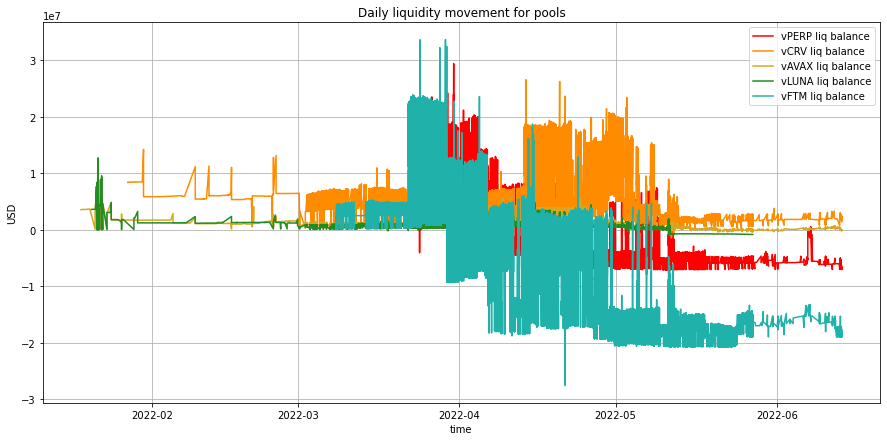

In [55]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vPERP", "vCRV", "vAVAX", "vLUNA", "vFTM"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement.index, pool_liquidity_movement["liquidity_balance"],
            color=colors[color_index], label=pool+' liq balance')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.grid()
ax.set_title("Daily liquidity movement for pools")
plt.show()

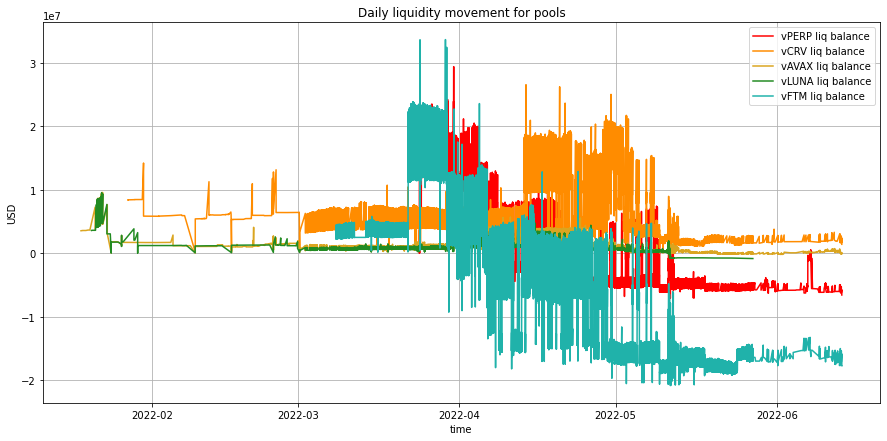

In [56]:
liquidity_changes_df.sort_values("block_number_log_index", inplace=True)
liquidity_changes_df = liquidity_changes_df.reset_index()
liquidity_changes_df.drop(columns=["index"], inplace=True)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
color_index = 0

colors = ["red", "darkorange", "goldenrod", "forestgreen", "lightseagreen", "steelblue", "blue", "purple", "deeppink"]

for pool in ["vPERP", "vCRV", "vAVAX", "vLUNA", "vFTM"]:
    pool_liquidity_movement = liquidity_changes_df[liquidity_changes_df["pool_name"] == pool]
    pool_liquidity_movement.set_index("time", inplace=True)
    pool_liquidity_movement["liquidity_balance"] = pool_liquidity_movement["fixed_liquidity"].cumsum()
    ax.plot(pool_liquidity_movement.index, pool_liquidity_movement["liquidity_balance"],
            color=colors[color_index], label=pool+' liq balance')
    color_index += 1
    
ax.set_xlabel("time")
ax.set_ylabel("USD")
ax.legend()
ax.grid()
ax.set_title("Daily liquidity movement for pools")
plt.show()